In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Helper (support)
from support import input_helper

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [5]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

In [6]:
pd.set_option('precision', 2)

* BE = Belgium
* FR = France
* EU = Europe
* FG = Flat Glass
* ArchFG = Architectural Flat Glass

# Upload Datasets

In [7]:
BE_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [8]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS', 'Population']

FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'Population', 'workforce', 'MatEnergy_WindowGlass', 'MatEnergy_PlateGlass', 'RawMat_Intensity', 'Energy_Intensity', 'RawMat_FlatGlass_ABS', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Flat Glass Production in Europe

## Creating a Dataframe for Flat Glass Flows

In [9]:
# Data relating to flat glass production
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])

In [10]:
# Adding import and export flows
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

In [11]:
# Creating a single dataframe for flat glass flows in Europe

EU = pd.concat([EU_Prod['flat glass, kt'],
                EU_Imp['flat glass, kt'],
                EU_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]'),
                                ('Import [kt]'),
                                ('Export [kt]')],
                  names=['Flow']).stack(dropna=False)

EU = EU.unstack()

In [12]:
EU

Flow                   Production [kt]  Import [kt]  Export [kt]
Nbr of countries year                                           
6                1945              NaN          NaN          NaN
                 1946              NaN          NaN          NaN
                 1947              NaN          NaN          NaN
                 1948              NaN          NaN          NaN
                 1949              NaN          NaN          NaN
...                                ...          ...          ...
28               2015           9641.0      1079.10      1187.54
                 2016           9835.0      1255.01      1192.21
                 2017          10665.0      1534.99      1158.69
                 2018          10643.0      1673.63      1178.92
                 2019          10840.0          NaN          NaN

[77 rows x 3 columns]

## Flat Glass Production

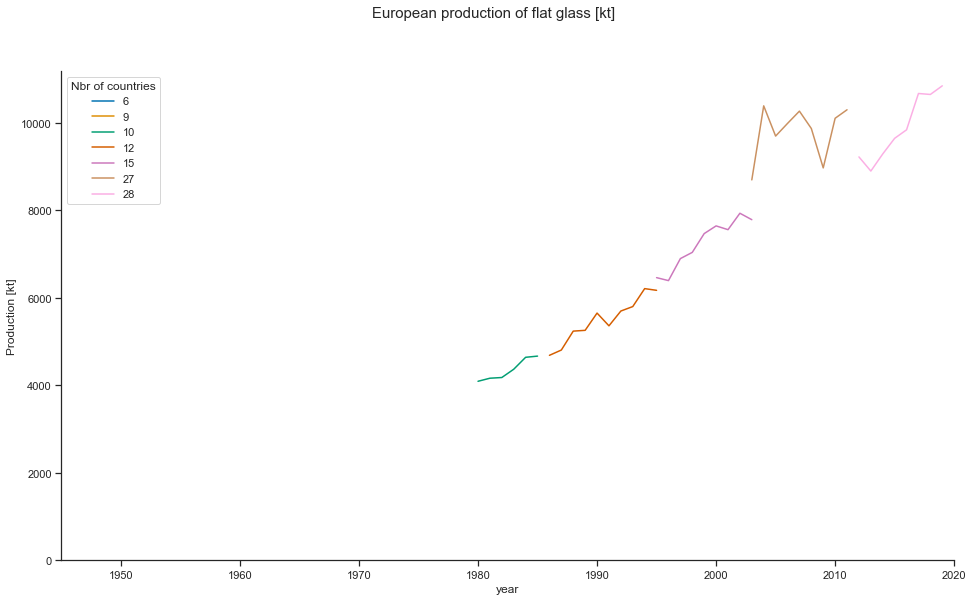

In [13]:
# Plot the European production of flat glass

EUplot = EU.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, 
             x = 'year', y = 'Production [kt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt]', fontsize = 15)
sns.despine()
plt.show()

## Flat Glass Consumption

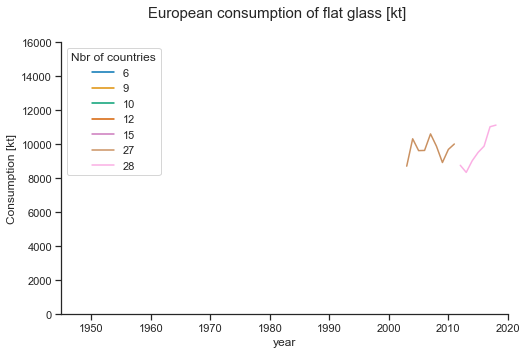

In [14]:
# Estimating consumption in EU
EU['Consumption [kt]'] = (EU['Production [kt]'] 
                          + EU['Import [kt]'] 
                          - EU['Export [kt]']
                         )

# Plotting the European consumption of flat glass

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data = EUplot, 
             x = 'year', y = 'Consumption [kt]', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0, 16000)

fig.suptitle('European consumption of flat glass [kt]', fontsize = 15)
sns.despine()
plt.show()

## Architectural Flat Glass Production

In [15]:
# Share of building glazing in the European production of flat glass
EUBldgShare = EU_Prod[['bldg glass/flat glass, %']].copy()

EUBldgShare = EUBldgShare.dropna()

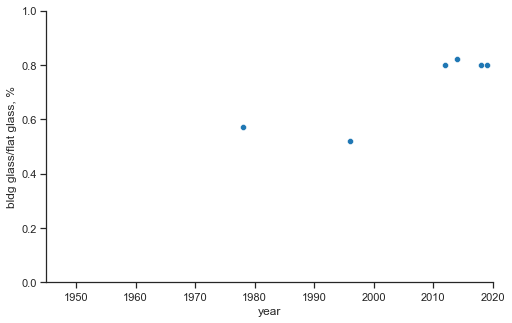

In [16]:
toplot = EUBldgShare.reset_index()

fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=toplot, 
                x='year', y='bldg glass/flat glass, %', 
                markers="o", ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,1)
sns.despine()

In [17]:
# Linear interpolation
EU['bldg glass/flat glass, %'] = (EU_Prod['bldg glass/flat glass, %']
                                       .interpolate(method="linear", 
                                                    limit_area='inside')
                                      )

In [18]:
# Calculation of EU production of architectural flat glass:
EU['arch glass production [kt]'] = (EU['Production [kt]']
                                         * EU['bldg glass/flat glass, %']
                                        )

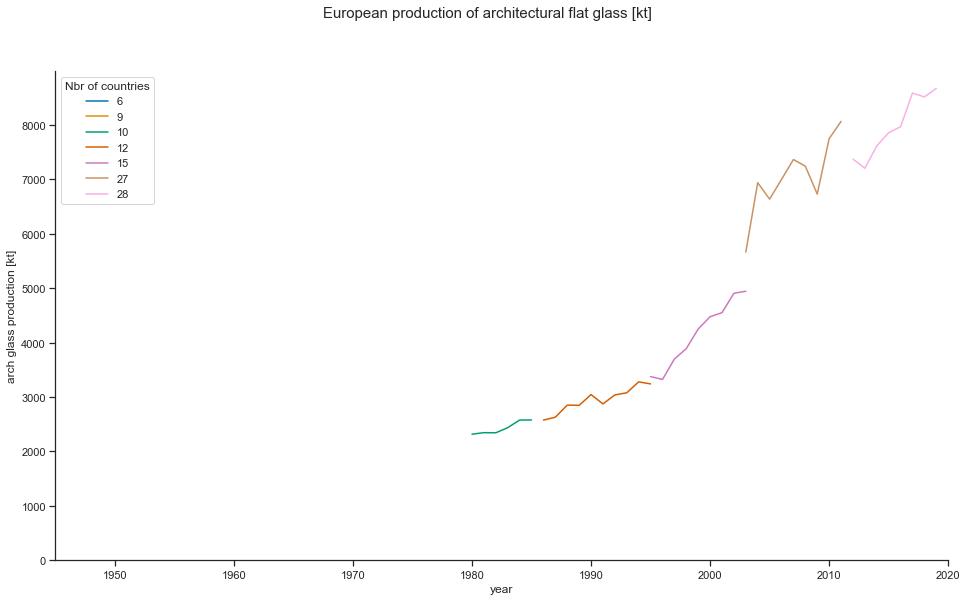

In [19]:
# Plot the European production of architectural flat glass

EUplot = EU.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, 
             x = 'year', y = 'arch glass production [kt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of architectural flat glass [kt]', 
             fontsize = 15)
sns.despine()
plt.show()

## Summary

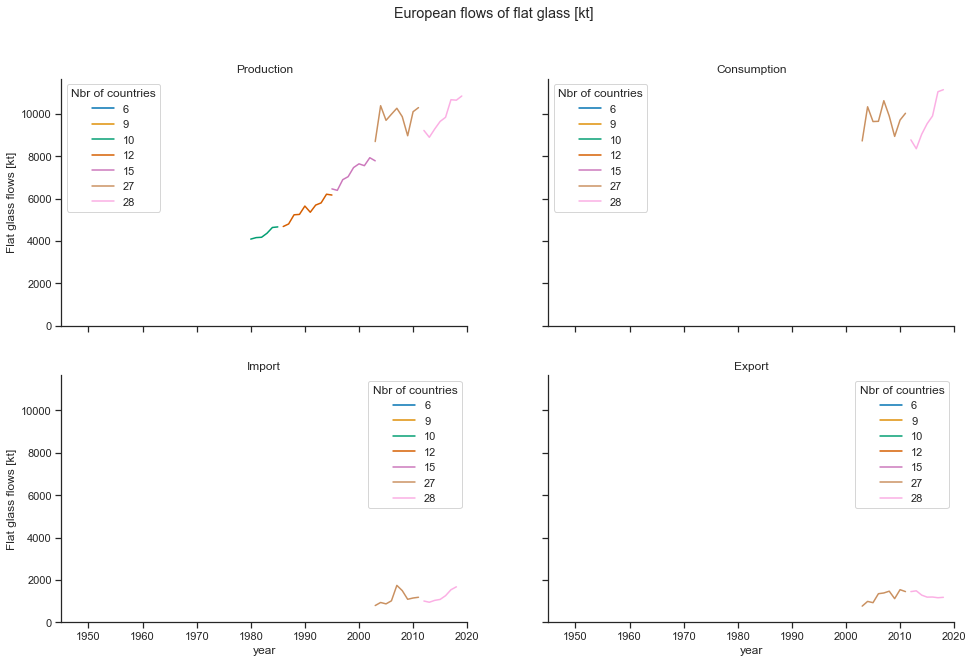

In [20]:
# Plotting import and export flows of flat glass

data1 = ['Production', 'Consumption']
data2 = ['Import', 'Export']

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,10))

for col, data in enumerate(data1):
    ax=axes[0][col]
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    ax.set_title(data)
    sns.lineplot(data=EUplot,
                 x='year', y=f"{data} [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    
for col, data in enumerate(data2):
    ax=axes[1][col]
    if col == 0:
        ax.set_ylabel('Flat glass flows [kt]')
    ax.set_title(data)
    sns.lineplot(data=EUplot,
                 x='year', y=f"{data} [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

fig.suptitle("European flows of flat glass [kt]")
sns.despine()
plt.show()

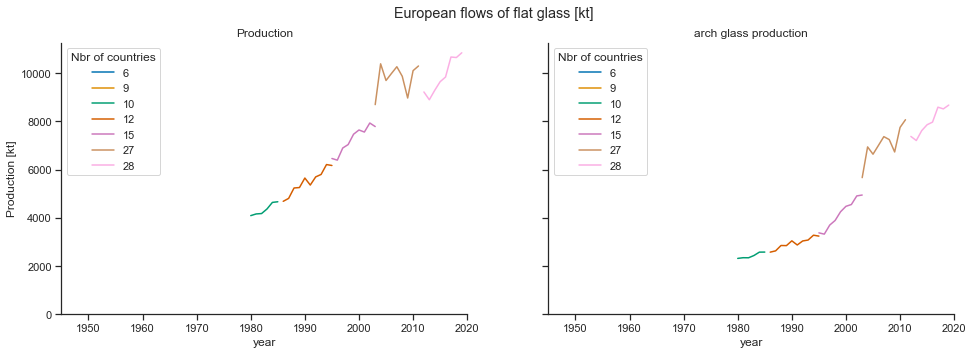

In [21]:
# Plotting import and export flows of flat glass

data = ['Production', 'arch glass production']

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for col, data in enumerate(data):
    ax=axes[col]
    ax.set_title(data)
    sns.lineplot(data=EUplot,
                 x='year', y=f"{data} [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

fig.suptitle("European flows of flat glass [kt]")
sns.despine()
plt.show()

# Flat Glass Production in France and Belgium

## Creating a Dataframe for Flat Glass Flows

In [22]:
# Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

# Creating a new DataFrame for Belgian and French flat glass production
BE_FR_FGProd = pd.concat([FR_Prod['flat glass, kt'],
                          BE_Prod['flat glass, kt']],
                         axis=1, keys=['FR [kt]', 'BE [kt]'])

BE_FR_FGProd

,FR [kt],BE [kt]
year,,
1945,108.3,NaN
1946,173.8,NaN
1947,198.3,NaN
1948,220.2,NaN
1949,191.3,NaN
...,...,...
2016,NaN,NaN
2017,NaN,NaN
2018,NaN,NaN


In [23]:
# Creating a DataFrame with import and export data
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [24]:
# Creating a unique DataFrame for French and Belgian flat glass flows
BE_FR = pd.concat([FR_Prod['flat glass, kt'], BE_Prod['flat glass, kt'],
                   FR_Imp['flat glass, kt'], BE_Imp['flat glass, kt'],
                   FR_Exp['flat glass, kt'], BE_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'), 
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'), 
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

BE_FR = BE_FR.unstack()

In [25]:
BE_FR

Info    Export [kt]         Import [kt]        Production [kt]       
Country     Belgium  France     Belgium France         Belgium France
year                                                                 
1945            NaN     NaN         NaN    NaN             NaN  108.3
1946            NaN     NaN         NaN    NaN             NaN  173.8
1947            NaN     NaN         NaN    NaN             NaN  198.3
1948            NaN     NaN         NaN    NaN             NaN  220.2
1949            NaN     NaN         NaN    NaN             NaN  191.3
...             ...     ...         ...    ...             ...    ...
2016         499.79  300.84      216.27  370.0             NaN    NaN
2017         547.19  333.31      230.96  401.0             NaN    NaN
2018         547.76  349.18      228.65  355.0             NaN    NaN
2019         986.33  451.42      254.22  352.0             NaN    NaN
2020            NaN     NaN         NaN  349.0             NaN    NaN

[76 rows x 6 columns]

## Production of flat glass

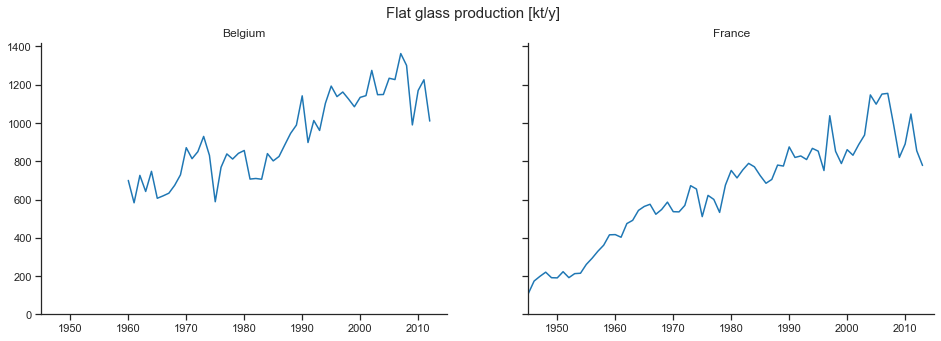

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Production [kt]'].index, BE_FR['Production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

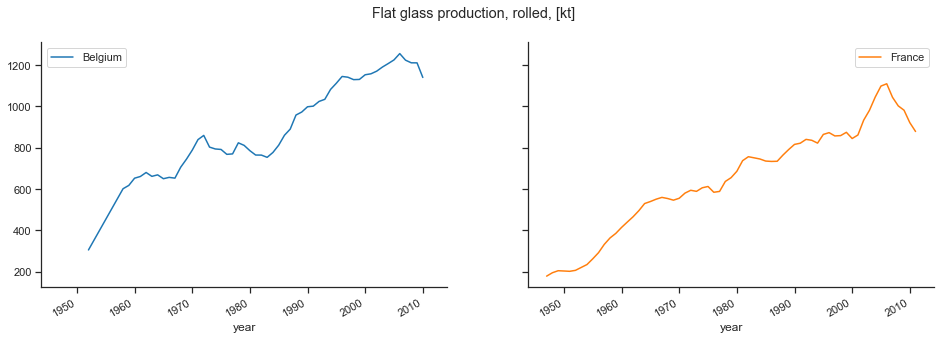

In [27]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of flat glass

In [28]:
BE_FR = BE_FR.stack()

BE_FR['Import Ratio'] = BE_FR['Import [kt]'] / BE_FR['Production [kt]']
BE_FR['Export Ratio'] = BE_FR['Export [kt]'] / BE_FR['Production [kt]']

BE_FR = BE_FR.unstack()

In [29]:
ratios = ['Import', 'Export']
countries = ['Belgium', 'France']

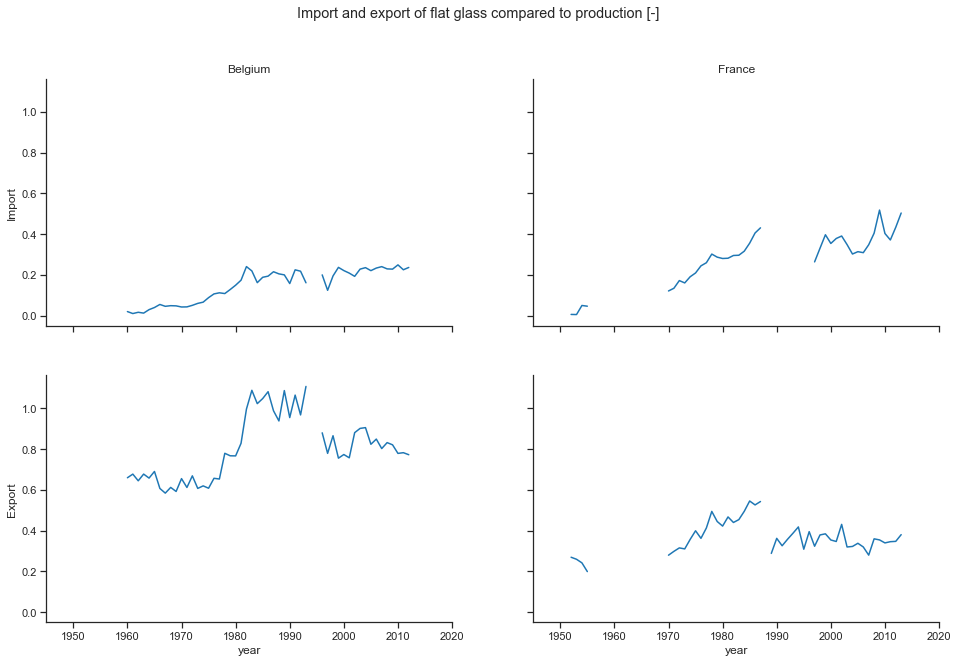

In [30]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} Ratio", country)]
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()
fig.suptitle("Import and export of flat glass compared to production [-]")
sns.despine()
plt.show()

In [31]:
# Interpolation for missing data
cols = [x for x in BE_FR.columns if x[0] in ['Import Ratio', 'Export Ratio']]

BE_FR[cols] = (BE_FR[cols].interpolate(method='linear'))

In [32]:
BE_FR.loc[1950:1960, cols]

Info    Import Ratio           Export Ratio       
Country      Belgium    France      Belgium France
year                                              
1950             NaN       NaN          NaN   0.29
1951             NaN       NaN          NaN   0.28
1952             NaN  5.99e-03          NaN   0.27
1953             NaN  5.33e-03          NaN   0.26
1954             NaN  4.99e-02          NaN   0.24
1955             NaN  4.64e-02          NaN   0.20
1956             NaN  4.47e-02          NaN   0.17
1957             NaN  4.30e-02          NaN   0.15
1958             NaN  4.14e-02          NaN   0.18
1959             NaN  3.97e-02          NaN   0.21
1960            0.02  3.80e-02         0.66   0.24

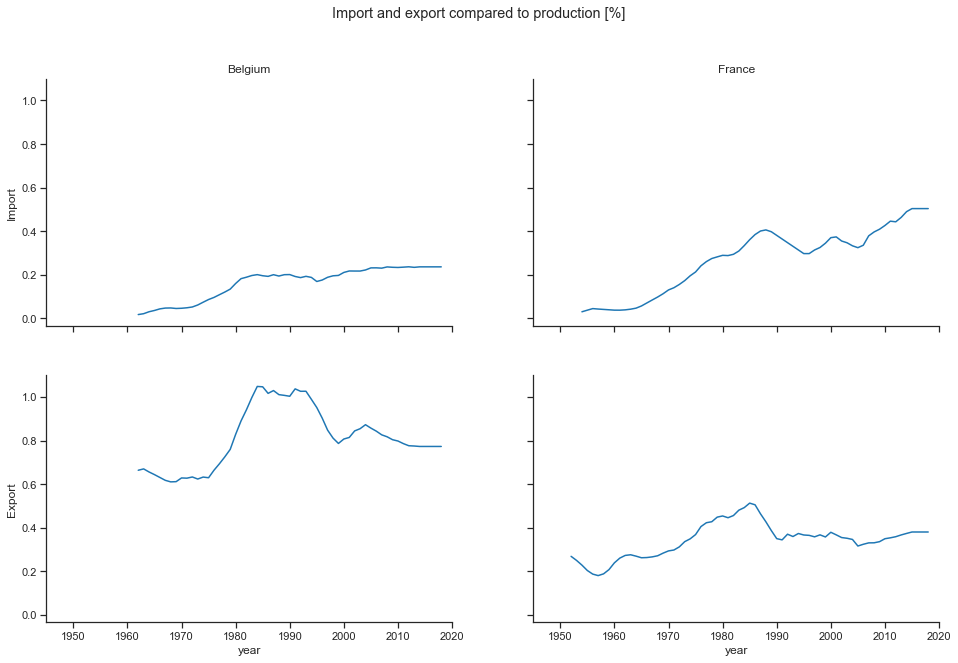

In [33]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} Ratio", country)]
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

fig.suptitle("Import and export compared to production [%]")
sns.despine()
plt.show()

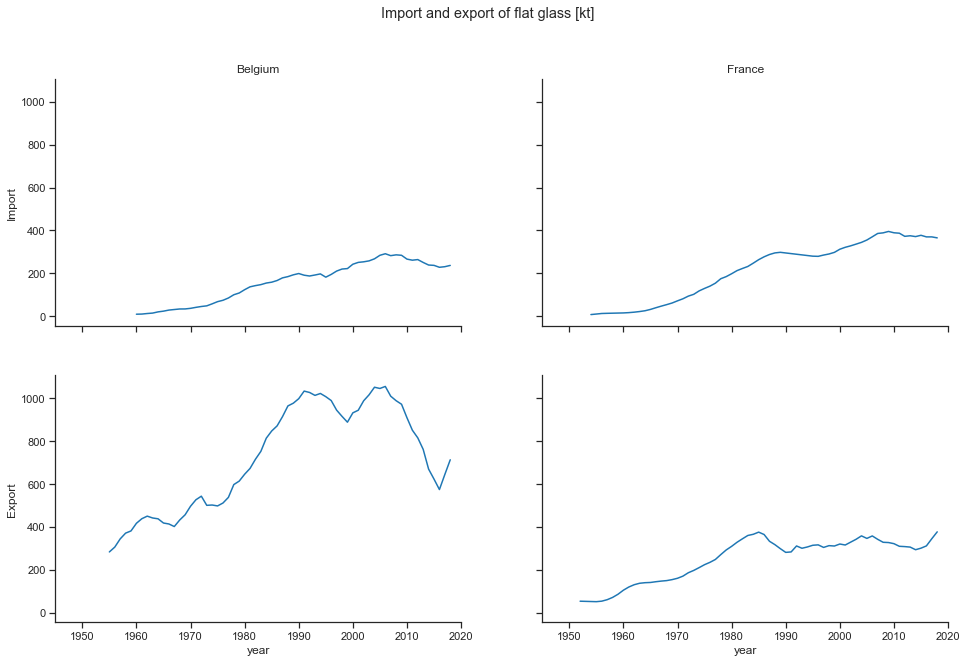

In [34]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} [kt]", country)]
         .interpolate(method='linear')
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

fig.suptitle("Import and export of flat glass [kt]")
sns.despine()
plt.show()

In [35]:
BE_FR = BE_FR.stack()

BE_FR['Consumption [kt]'] = (BE_FR['Production [kt]']
                                         + BE_FR['Import Ratio'] 
                                         * BE_FR['Production [kt]']
                                         - BE_FR['Export Ratio'] 
                                         * BE_FR['Production [kt]']
                            )

BE_FR = BE_FR.unstack()

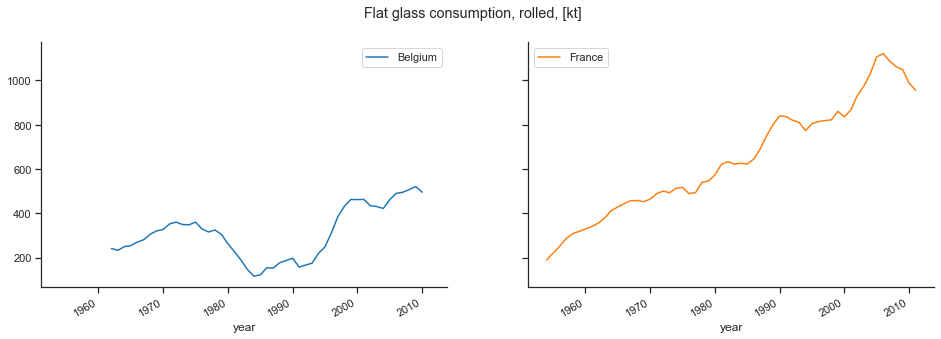

In [36]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Flat glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [37]:
# Creating a DataFrame with import and export data
FR_Pop = FR_data.parse('Population').set_index('year')
BE_Pop = BE_data.parse('Population').set_index('year')

In [38]:
# Creating a unique DataFrame for French and Belgian population
BE_FR_Pop = pd.concat([FR_Pop['Population, x1000'],
                       BE_Pop['Population, x1000']],
                      axis=1, keys=[('Population [x1000]', 'France'),
                                    ('Population [x1000]', 'Belgium')],
                      names=['Info', 'Country']).stack()

BE_FR_Pop = BE_FR_Pop.unstack()

In [39]:
BE_FR_Pop[('Population [x1000]', 'Belgium')] = (
    BE_FR_Pop[('Population [x1000]', 'Belgium')].interpolate(method='linear')
)

In [40]:
# Estimate the consumption per capita
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR[('Consumption [kg/cap]', country)] = (
        BE_FR[('Consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

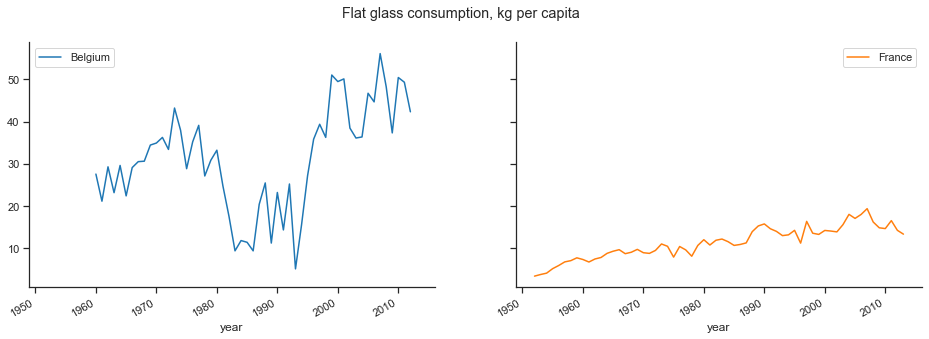

In [41]:
(BE_FR['Consumption [kg/cap]']
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title=("Flat glass consumption, kg per capita")
      )
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

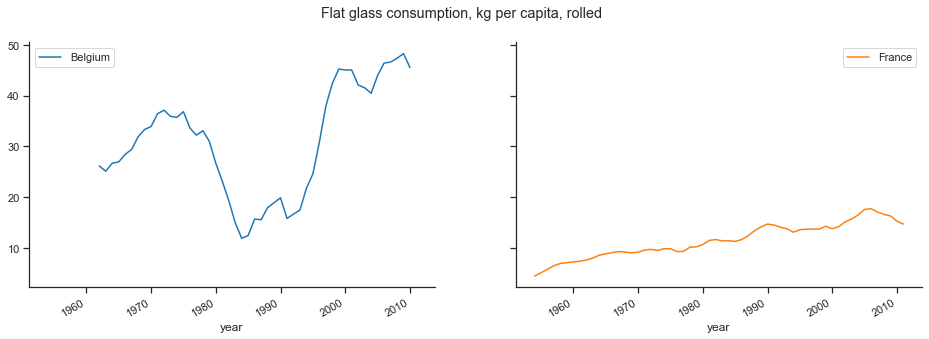

In [42]:
((BE_FR['Consumption [kg/cap]']
     .rolling(5, center = True)
     .mean())
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Flat glass consumption, kg per capita, rolled")
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Production of architectural flat glass

In [43]:
# Share of building glass in the French production of flat glass

ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()

print(ShareFR.isnull().sum())
ShareFR

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1945,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49
2009,0.52


In [44]:
ShareFR['Trend'] = FR_Prod[['bldg glass/flat glass, %']].copy()

ShareFR = ShareFR.reset_index()

x = np.array(list(ShareFR['year']))
y = np.array(list(ShareFR['Trend']))

ShareFR = ShareFR.set_index('year')

# Order of the regression:
n = 3

# Polynomial coefficients and covariance matrix:
coeffs, cov = np.polyfit(x, y, n, cov=True)

results = {}
results['Polynomial'] = coeffs.tolist()
results['Covariance'] = cov.tolist()

# Interpolation:
t = np.linspace(1945, 2020, 76)

# Matrix with rows 1, t, t**2...:
TT = np.vstack([t**(n-i) for i in range(1+n)]).T

# Matrix multiplication for the polynomial values:
z = np.dot(TT, coeffs)

# Standard deviations (sqrt of diagonal):
sig = np.sqrt(
    np.diag(
        np.dot(TT, np.dot(cov, TT.T))
              ))

# r-squared
p = np.poly1d(coeffs)
# fit values, and mean
yhat = p(x)                      # vector y = p(z) for z in x
ybar = np.sum(y)/len(y)          # mean of y data
SSres = np.sum((yhat-ybar)**2)   # residual sum of squares
SStot = np.sum((y - ybar)**2)    # total sum squares
results['Coefficient of determination'] = SSres / SStot

results

{'Polynomial': [-2.378960893414362e-06,
  0.014301359629274039,
  -28.656983590865888,
  19140.70797173813],
 'Covariance': [[2.8029866613415203e-12,
   -1.6645777335936083e-08,
   3.2948302953039774e-05,
   -0.021737417444942602],
  [-1.6645777335958778e-08,
   9.88533429177357e-05,
   -0.19567014611392025,
   129.09330281953902],
  [3.294830295312971e-05,
   -0.1956701461141876,
   387.3129582861321,
   -255532.078955934],
  [-0.021737417445031697,
   129.09330281989222,
   -255532.0789562839,
   168590499.05965033]],
 'Coefficient of determination': 0.9311453347637837}

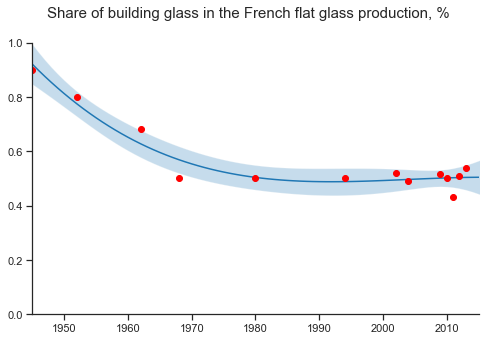

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(t, z+1.96*sig, z-1.96*sig, alpha=0.25)
ax.plot(t, z,'-')
ax.plot(x, y, 'ro')

ax.set_ylim(0,1)
ax.set_xlim(1945,2015)

fig.suptitle('Share of building glass in the French flat glass production, %', 
             fontsize = 15)
sns.despine()
plt.show()

In [46]:
len(z.tolist())

76

In [47]:
#Create a dataframe for ratio arch glass/tot flat glass:
BldgShare = FR_Prod[['bldg glass/flat glass, %']].copy()

# Interpolate values according to 
# nonlinear regression previously estimated
BldgShare['Mean ratio arch glass/flat glass, %'] = z.tolist()

# Integrate standard deviation in FR_Prod
BldgShare['std for ratio arch glass/flat glass'] = sig.tolist()

BldgShare


,"bldg glass/flat glass, %","Mean ratio arch glass/flat glass, %",std for ratio arch glass/flat glass
year,,,
1945,0.9,0.92,0.04
1946,NaN,0.90,0.03
1947,NaN,0.87,0.03
1948,NaN,0.85,0.03
1949,NaN,0.83,0.03
...,...,...,...
2016,NaN,0.50,0.04
2017,NaN,0.50,0.04
2018,NaN,0.50,0.05


In [48]:
# Estimate architectural flat glass production in France and Belgium
for country in countries:
    BE_FR[('Architectural glass production [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['Mean ratio arch glass/flat glass, %']
    )
    
for country in countries:
    BE_FR[('std for architectural glass production', country)] = (
    BE_FR[('Production [kt]', country)]
    * BldgShare['std for ratio arch glass/flat glass']
    )

In [49]:
x = np.array(BE_FR['Architectural glass production [kt]'].index)

yminFR= np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                 +1.96
                 *BE_FR[('std for architectural glass production', 'France')])
ymaxFR = np.array(BE_FR[('Architectural glass production [kt]', 'France')]
                  -1.96
                  *BE_FR[('std for architectural glass production', 'France')])

yminBE= np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                 +1.96
                 *BE_FR[('std for architectural glass production', 'Belgium')])
ymaxBE = np.array(BE_FR[('Architectural glass production [kt]', 'Belgium')]
                -1.96
                  *BE_FR[('std for architectural glass production', 'Belgium')])

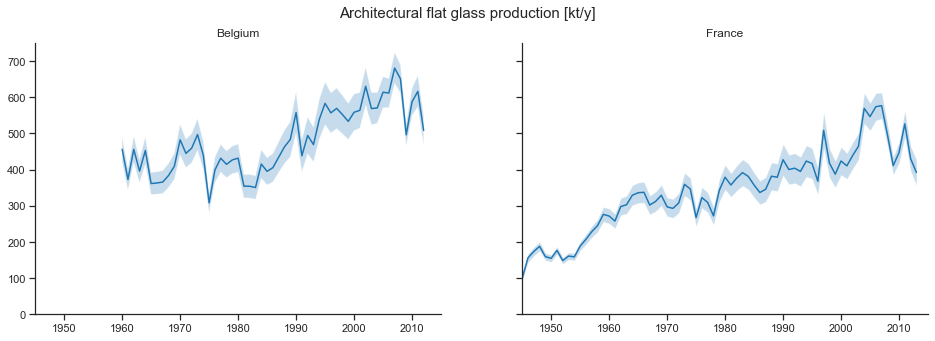

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            BE_FR['Architectural glass production [kt]'][col])
    if col == 'France':
        ax.fill_between(x, yminFR, ymaxFR, alpha=0.25)
    elif col == 'Belgium':
        ax.fill_between(x, yminBE, ymaxBE, alpha=0.25)
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

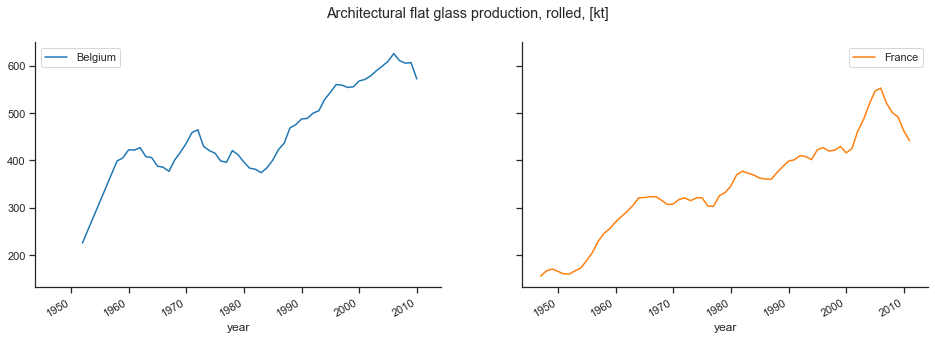

In [51]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Architectural flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [52]:
yminFR= np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                  .rolling(5, center = True).mean())
                 +1.96*BE_FR[('std for architectural glass production', 
                              'France')]
                )
ymaxFR = np.array((BE_FR[('Architectural glass production [kt]', 'France')]
                   .rolling(5, center = True).mean())
                  -1.96*BE_FR[('std for architectural glass production', 
                               'France')]
                 )

yminBE= np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                  .rolling(5, center = True).mean())
                 +1.96*BE_FR[('std for architectural glass production', 
                              'Belgium')]
                )
ymaxBE = np.array((BE_FR[('Architectural glass production [kt]', 'Belgium')]
                   .rolling(5, center = True).mean())
                -1.96*BE_FR[('std for architectural glass production', 
                             'Belgium')]
                 )

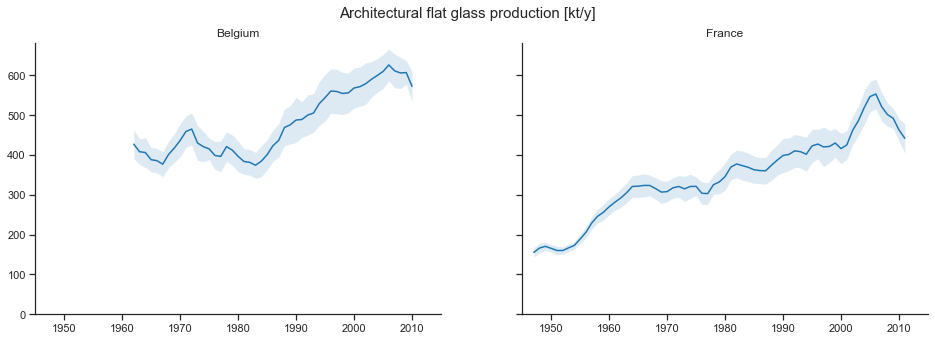

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 5), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(),
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):
    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            (BE_FR['Architectural glass production [kt]'][col]
             .rolling(5, center = True).mean())
           )
    if col == 'France':
            ax.fill_between(x, yminFR, ymaxFR, alpha=0.15)
    elif col == 'Belgium':
            ax.fill_between(x, yminBE, ymaxBE, alpha=0.15)
            
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

## Consumption of architectural flat glass

In [54]:
BE_FR = BE_FR.stack()

BE_FR['Architectural glass consumption [kt]'] = (
    BE_FR['Architectural glass production [kt]']
    + BE_FR['Import Ratio'] * BE_FR['Architectural glass production [kt]']
    - BE_FR['Export Ratio'] * BE_FR['Architectural glass production [kt]']
)

BE_FR = BE_FR.unstack()

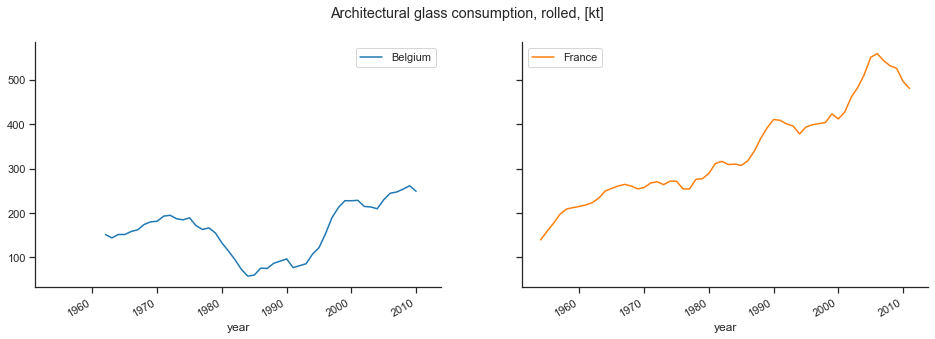

In [55]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="Architectural glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [56]:
# Estimate the consumption per capita
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR[('Architectural glass consumption [kg/cap]', 
           country)] = (
        BE_FR[('Architectural glass consumption [kt]', country)]
        / BE_FR_Pop[('Population [x1000]', country)] * 1000)

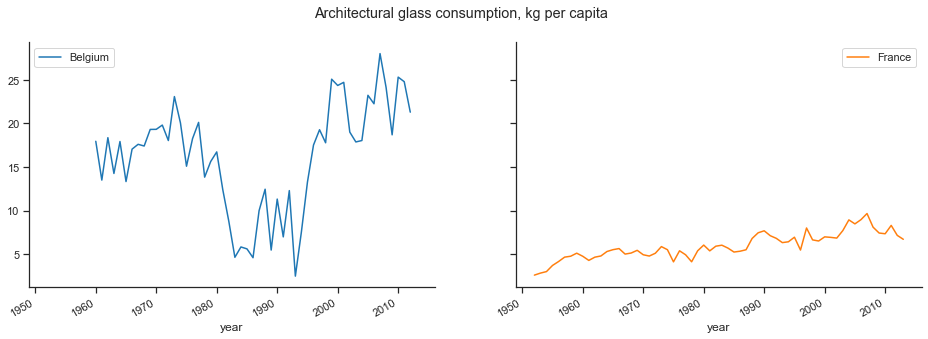

In [57]:
(BE_FR['Architectural glass consumption [kg/cap]']
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title=("Architectural glass consumption, kg per capita")
      )
)
    
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

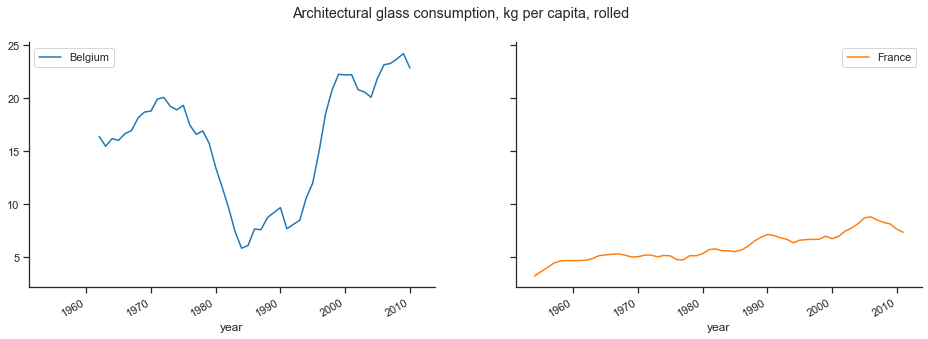

In [58]:
((BE_FR['Architectural glass consumption [kg/cap]']
     .rolling(5, center = True)
     .mean())
 .plot(subplots=True, 
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Architectural glass consumption, kg per capita, rolled")
)

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# Material, Energy and Carbon Intensity in the Flat Glass Industry

## Material intensity since 1945

In [59]:
# Creating a DataFrame for material intensity
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

In [60]:
MatIntensity['cullet, kg/kg'] = (MatIntensity['internal cullet, kg/kg'] 
                          + MatIntensity['external cullet, kg/kg'])

In [61]:
# Interpolating the raw material intensity dataset
MatIntensity = MatIntensity.interpolate(method='pchip',
                                         limit_direction='forward')

In [62]:
materials = ['cullet', 'sand', 'sodium carbonate',
             'limestone', 'dolomite', 'feldspar']

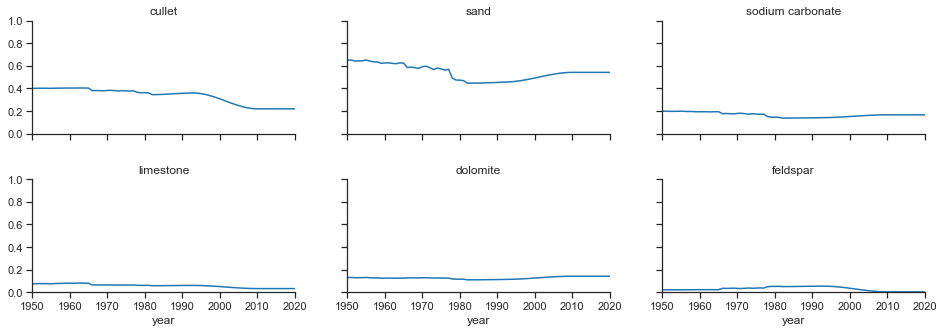

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    MatIntensity[(f"{mat}, kg/kg")].plot(ax=ax)
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

fig.subplots_adjust(hspace = 0.4)

sns.despine()
plt.show()

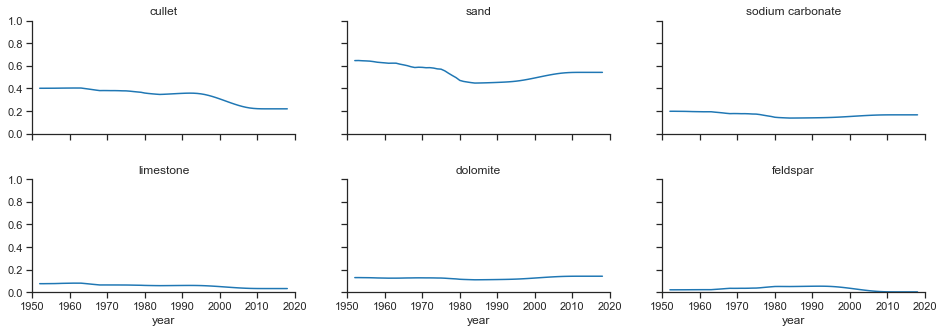

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    (MatIntensity[(f"{mat}, kg/kg")]
     .rolling(5, center = True).mean()
     .plot(ax=ax)
    )
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

# fig.tight_layout(pad=1.0)
fig.subplots_adjust(hspace = 0.4)

sns.despine()
plt.show()

In [65]:
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[(f"{mat}, kg/kg")] 
        + MatIntensity['Total raw materials, kg/kg']
    )

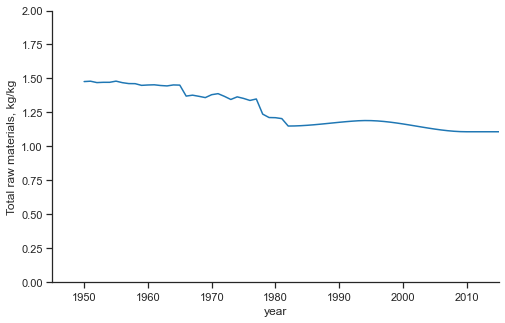

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = 'Total raw materials, kg/kg',
             ax=ax)

ax.set_xlim(1945,2015)
ax.set_ylim(0,2)
sns.despine()
plt.show()

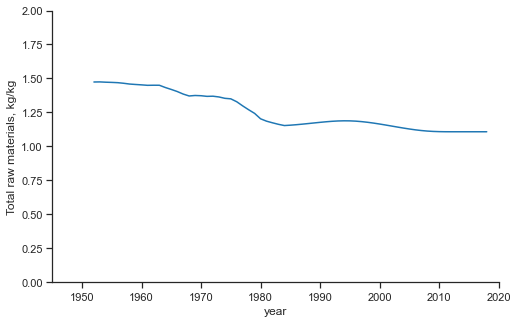

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = (MatIntensity['Total raw materials, kg/kg']
                  .rolling(5, center = True).mean()),
             ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,2)
sns.despine()
plt.show()

## Energy intensity since 1945

In [68]:
# Creating a DataFrame for energy intensity
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [69]:
# Interpolating the raw material intensity dataset
EnergyIntensity = EnergyIntensity.interpolate(method='pchip',
                                              limit_direction='forward')

In [70]:
energies = ['fuel', 'natural gas', 'electricity']

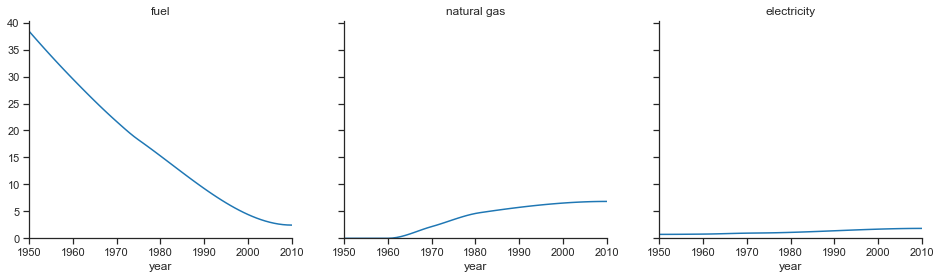

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, GJ/t")].plot(ax=ax)
    
ax.set_xlim(1950,2010)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [72]:
EnergyIntensity['Total energy, GJ/t'] = 0

for energy in energies:

    EnergyIntensity['Total energy, GJ/t'] = (
        EnergyIntensity['Total energy, GJ/t']
        + EnergyIntensity[(f"{energy}, GJ/t")]
    )

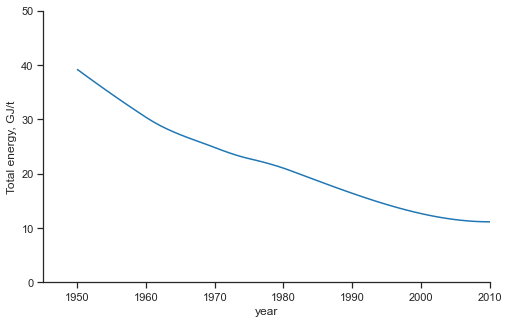

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data = EnergyIntensity, 
             x = EnergyIntensity.index, 
             y = 'Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945,2010)
ax.set_ylim(0,50)
sns.despine()
plt.show()

In [74]:
for energy in energies:
    EnergyIntensity[(f"{energy}, %")] = 0
    
    for energy in energies:
        EnergyIntensity[(f"{energy}, %")] = (
            EnergyIntensity[(f"{energy}, GJ/t")]
            / EnergyIntensity['Total energy, GJ/t']
        )

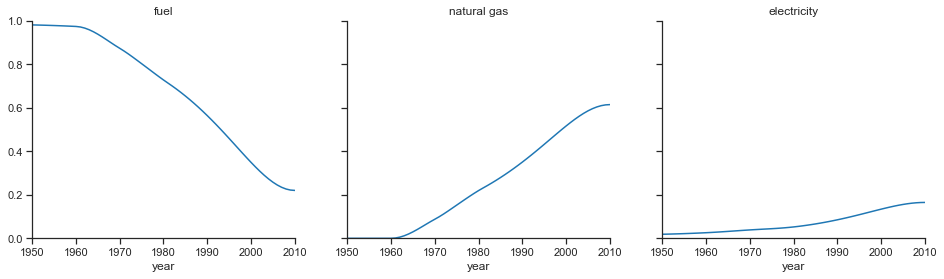

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, %")].plot(ax=ax)
    
ax.set_xlim(1950,2010)
ax.set_ylim(0,1)
sns.despine()
plt.show()

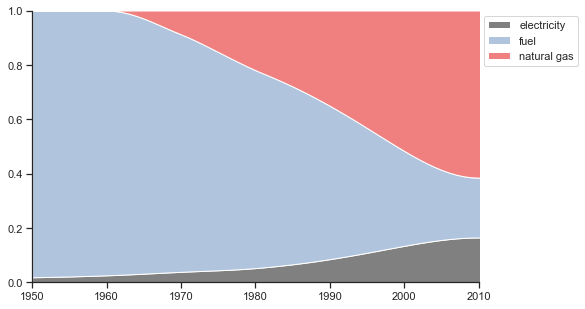

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))

y=np.array([EnergyIntensity['electricity, %'].dropna(),
            EnergyIntensity['fuel, %'].dropna(), 
            EnergyIntensity['natural gas, %'].dropna()]
          )

x=range(1950,2021)

plt.stackplot(x,y, 
              labels=['electricity','fuel','natural gas'], 
              colors = ["grey", "lightsteelblue", "lightcoral"])
plt.legend(loc='upper left')

ax.set_xlim(1950,2010)
ax.set_ylim(0,1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()
plt.show()

## Carbon Intensity of the Flat Glass Production Process

In [77]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t':'CO2 [kg/t]'}, 
           inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


In [78]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

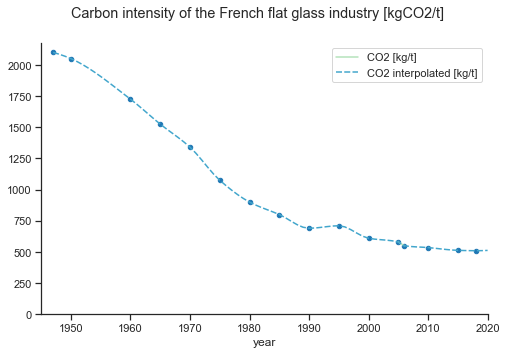

In [79]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle("Carbon intensity of the French flat glass industry [kgCO2/t]")
sns.despine()
plt.show()

# Raw Material and Energy Use in the European Flat Glass Industry

## Use of raw materials in the production of flat glass

In [97]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, flat glass [kt]"] = (
        EU['Production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

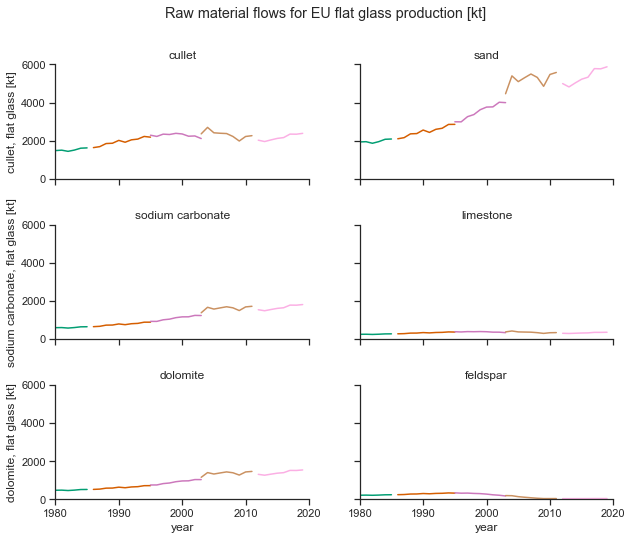

In [98]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10,8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, flat glass [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(material)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for EU flat glass production [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [99]:
EU['Total raw materials, flat glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, flat glass [Mt]'] = (
        EU[f"{material}, flat glass [kt]"]/1000 
        + EU['Total raw materials, flat glass [Mt]']
    )

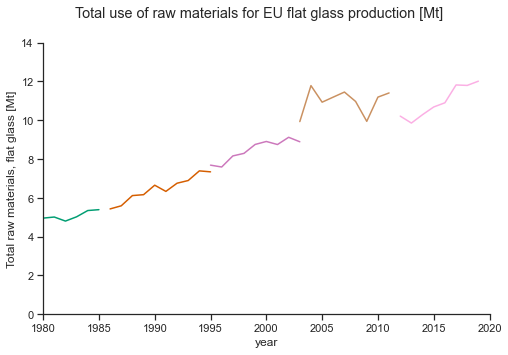

In [100]:
# Plot total material flows for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

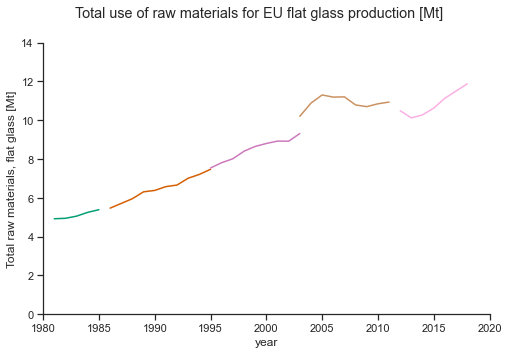

In [101]:
# Plot total material flows for EU flat glass production

EUplot = EU.rolling(3, center = True).mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, flat glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,14)
ax.get_legend().remove()

fig.suptitle("Total use of raw materials for EU flat glass production [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [102]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, flat glass [PJ]"] = (
        EU['Production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

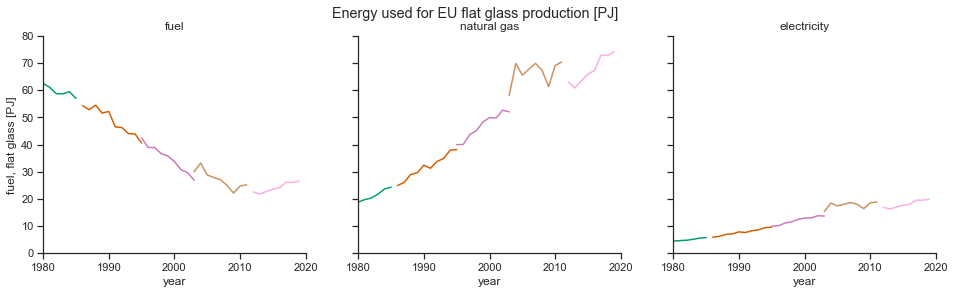

In [103]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, flat glass [PJ]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(energy)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0, 80)
    ax.get_legend().remove()

fig.suptitle("Energy used for EU flat glass production [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [106]:
EU['Total energy, flat glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, flat glass [PJ]'] = (
        EU[f"{energy}, flat glass [PJ]"] 
        + EU['Total energy, flat glass [PJ]']
    )

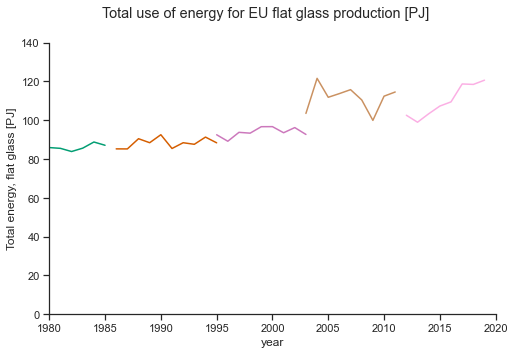

In [107]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, flat glass [PJ]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,140)
ax.get_legend().remove()

fig.suptitle("Total use of energy for EU flat glass production [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Use of raw materials in the production of architectural flat glass

In [108]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    EU[f"{mat}, arch glass [kt]"] = (
        EU['arch glass production [kt]']
        * MatIntensity[(f"{mat}, kg/kg")]
    )

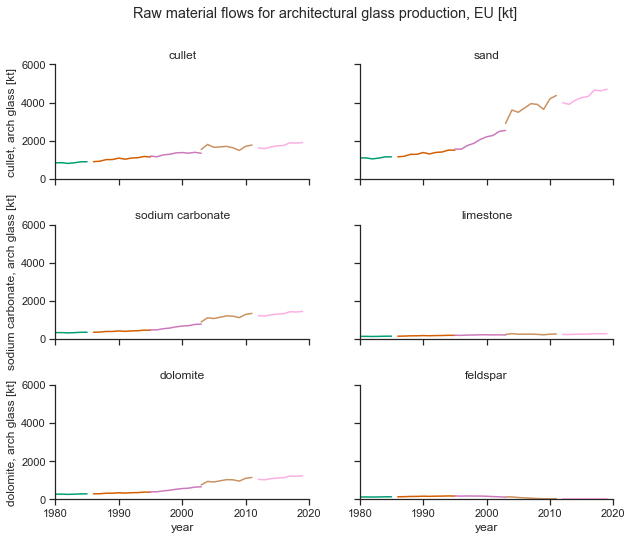

In [109]:
# Plot raw material flows for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=3, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(10,8))

for i, (ax, material) in enumerate(zip(axes.flatten(), materials)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{material}, arch glass [kt]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(material)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,6000)
    ax.get_legend().remove()

fig.suptitle("Raw material flows for architectural glass production, EU [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [110]:
EU['Total raw materials, arch glass [Mt]'] = 0

for material in materials:
    EU['Total raw materials, arch glass [Mt]'] = (
        EU[f"{material}, arch glass [kt]"]/1000 
        + EU['Total raw materials, arch glass [Mt]']
    )

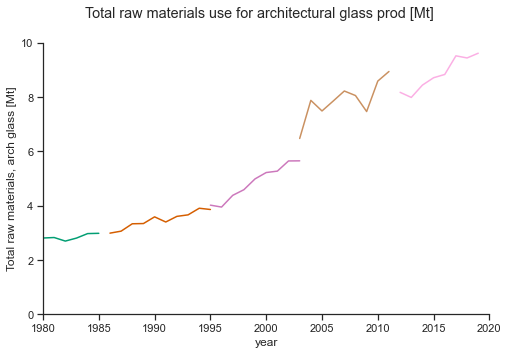

In [111]:
# Plot total material flows for EU architectural glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total raw materials, arch glass [Mt]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,10)
ax.get_legend().remove()

fig.suptitle("Total raw materials use for architectural glass prod [Mt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Energy Use in the production of architectural flat glass

In [112]:
# Absolute use of energy for flat glass production:
for energy in energies:
    EU[f"{energy}, arch glass [PJ]"] = (
        EU['arch glass production [kt]']
        * EnergyIntensity[(f"{energy}, GJ/t")]/1000
    )

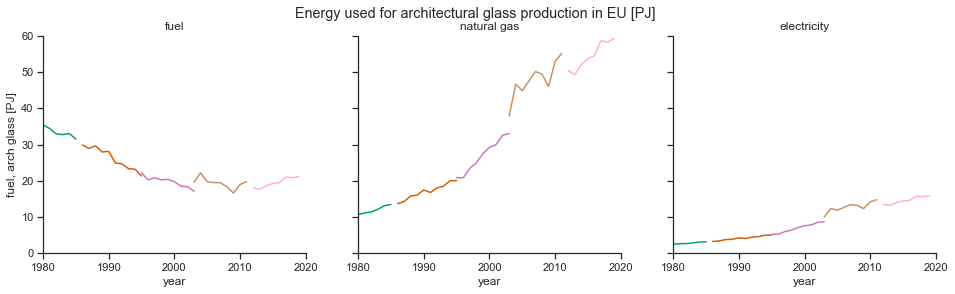

In [114]:
# Plot energy used for EU flat glass production

EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{energy}, arch glass [PJ]",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(energy)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0, 60)
    ax.get_legend().remove()

fig.suptitle("Energy used for architectural glass production in EU [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

In [115]:
EU['Total energy, arch glass [PJ]'] = 0

for energy in energies:
    EU['Total energy, arch glass [PJ]'] = (
        EU[f"{energy}, arch glass [PJ]"] 
        + EU['Total energy, arch glass [PJ]']
    )

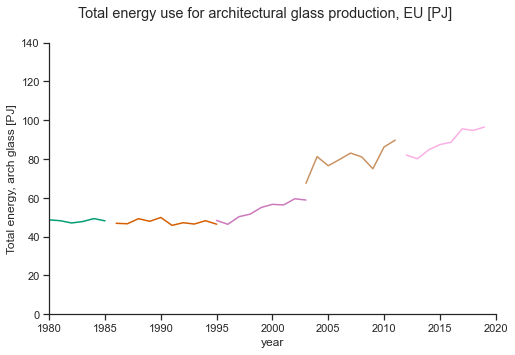

In [116]:
# Plot total energy use for EU flat glass production

EUplot = EU.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=EUplot,
             x='year', y='Total energy, arch glass [PJ]',
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1980,2020)
ax.set_ylim(0,140)
ax.get_legend().remove()

fig.suptitle("Total energy use for architectural glass production, EU [PJ]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Summary

# Raw Material and Energy Use in the Belgian and French Flat Glass Industry

## Use of raw materials in the production of flat glass

In [117]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{mat}, flat glass [kt]", country)] = (
            BE_FR[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

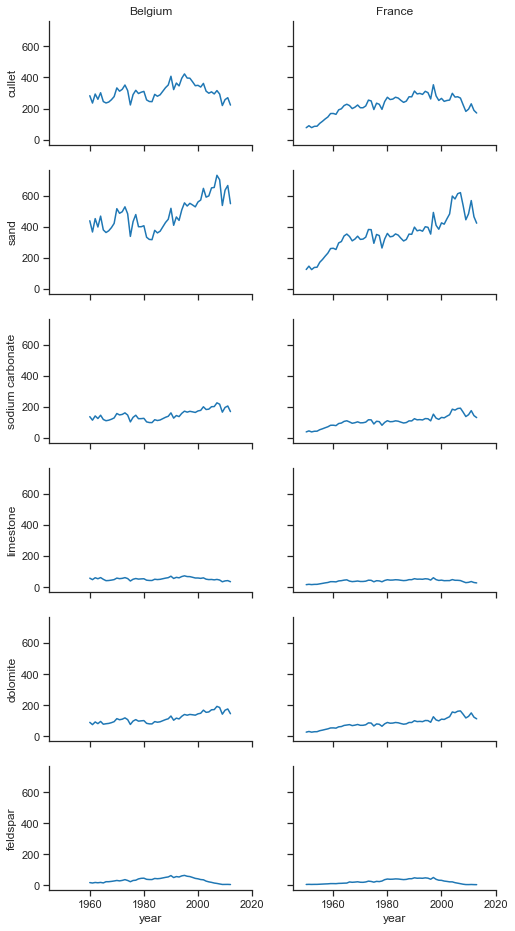

In [118]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16))
for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, flat glass [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

In [119]:
BE_FR['Total raw material use, flat glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, flat glass [kt]'] = (
        BE_FR[(f"{material}, flat glass [kt]", country)] 
        + BE_FR['Total raw material use, flat glass [kt]']
    )

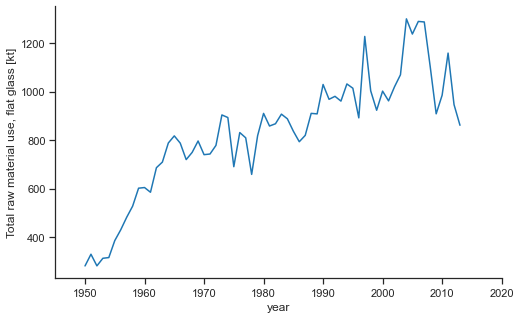

In [120]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total raw material use, flat glass [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

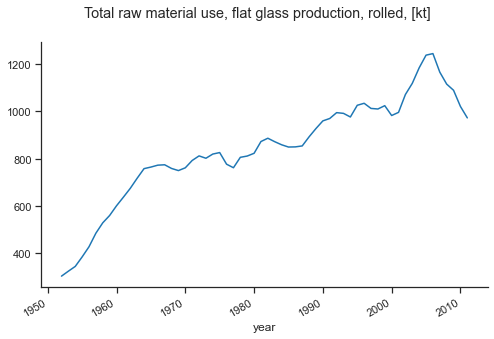

In [121]:
(BE_FR['Total raw material use, flat glass [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, flat glass production, rolled, [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [122]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{energy}, flat glass [TJ]", country)] = (
            BE_FR[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

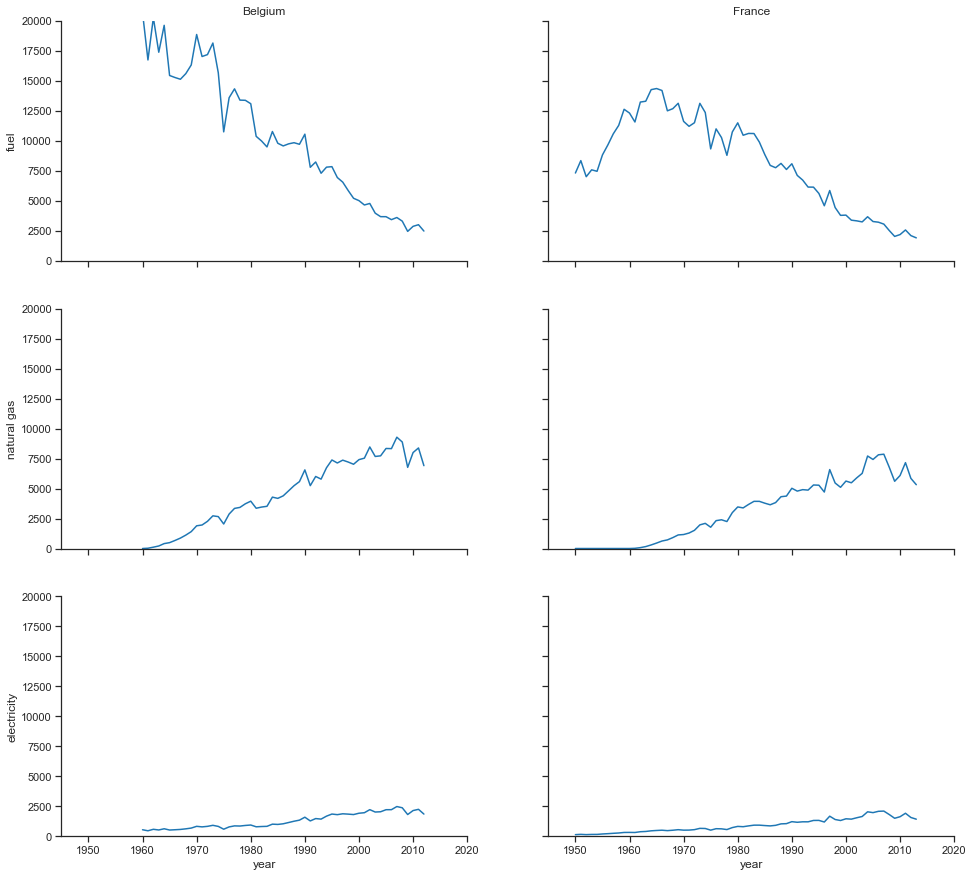

In [123]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16, 15))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, flat glass [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(0,20000)

sns.despine()
plt.show()

In [124]:
BE_FR['Total energy use, flat glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, flat glass [TJ]'] = (
        BE_FR[(f"{energy}, flat glass [TJ]", country)] 
        + BE_FR['Total energy use, flat glass [TJ]']
    )

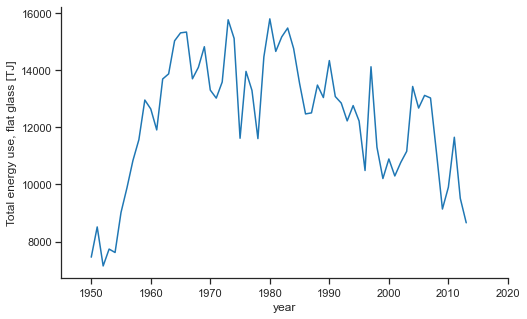

In [125]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total energy use, flat glass [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

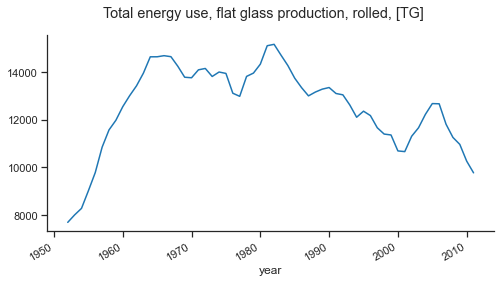

In [126]:
(BE_FR['Total energy use, flat glass [TJ]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total energy use, flat glass production, rolled, [TG]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Use of raw materials in the production of architectural flat glass

In [127]:
# Absolute use of raw materials for architectural flat glass production:
for mat in materials:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{mat}, architectural glass [kt]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

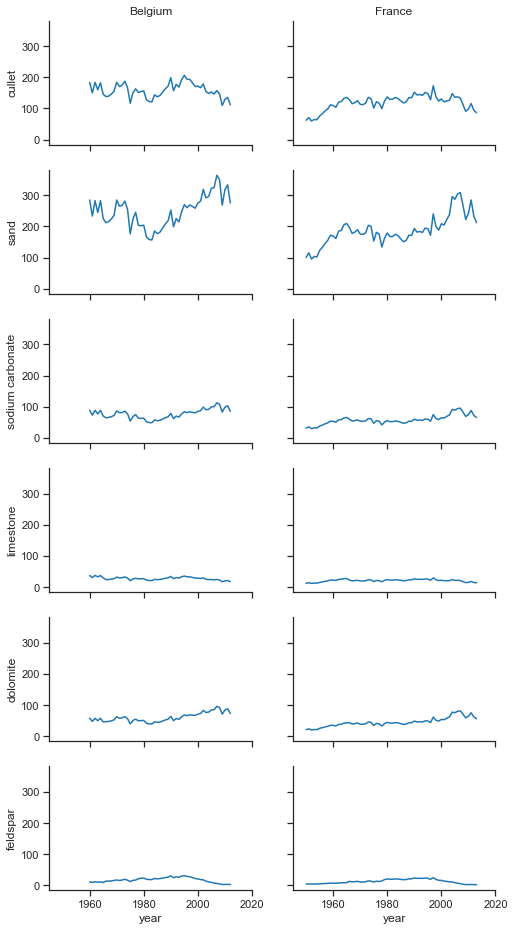

In [128]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16)
                        )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, architectural glass [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

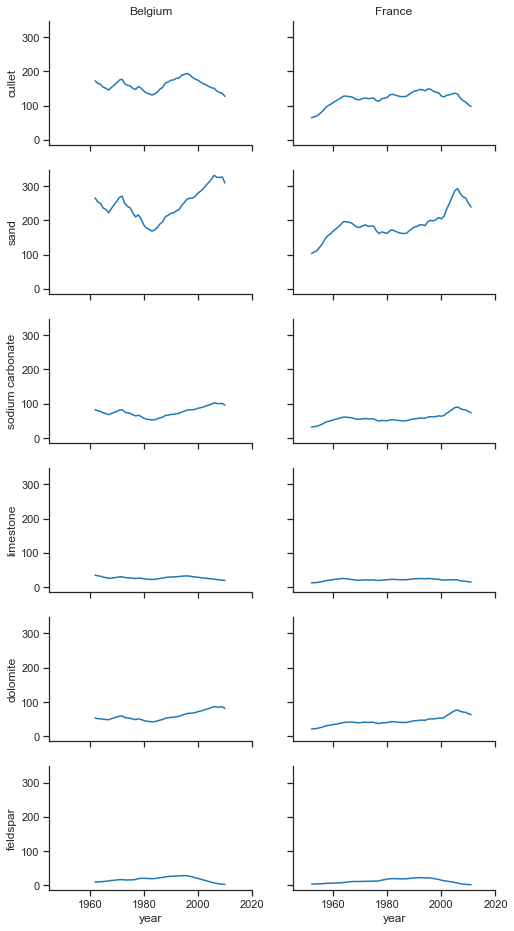

In [129]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16)
                        )

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        (BE_FR[(f"{material}, architectural glass [kt]", country)]
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [130]:
BE_FR['Total raw material use, architectural glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, architectural glass [kt]'] = (
        BE_FR[(f"{material}, architectural glass [kt]", country)] 
        + BE_FR['Total raw material use, architectural glass [kt]']
    )

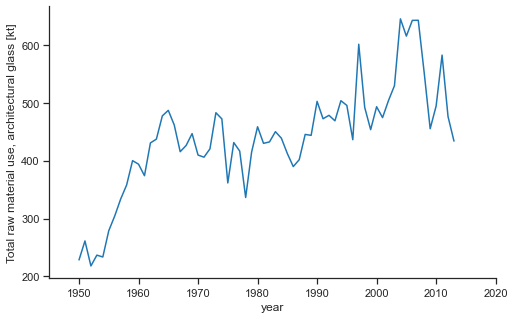

In [131]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total raw material use, architectural glass [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

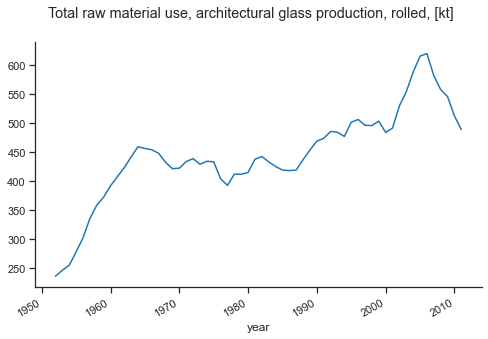

In [132]:
(BE_FR['Total raw material use, architectural glass [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, architectural glass production, rolled, [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy Use in the production of architectural flat glass

In [133]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Architectural glass production [kt]'].columns:
        BE_FR[(f"{energy}, architectural glass [TJ]", country)] = (
            BE_FR[('Architectural glass production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

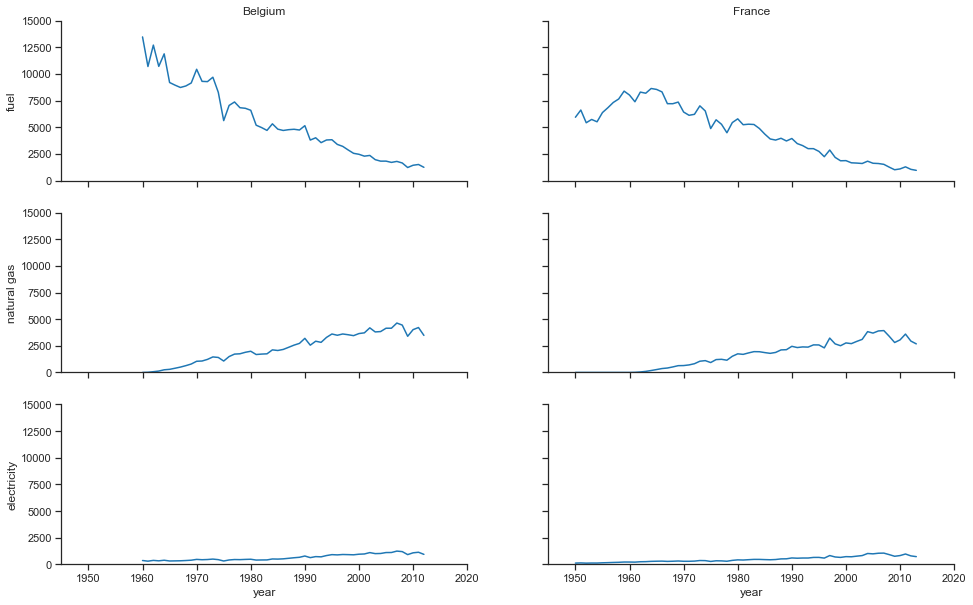

In [134]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10)
                        )

for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, architectural glass [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(0,15000)

sns.despine()
plt.show()

In [135]:
BE_FR['Total energy use, architectural glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, architectural glass [TJ]'] = (
        BE_FR[(f"{energy}, architectural glass [TJ]", country)] 
        + BE_FR['Total energy use, architectural glass [TJ]']
    )

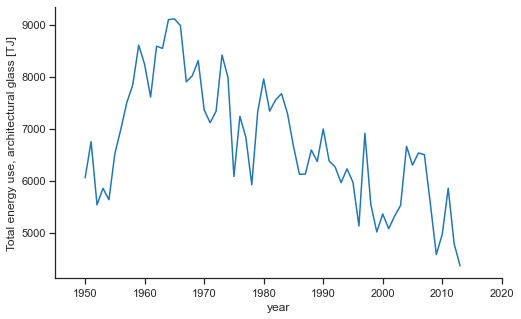

In [136]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total energy use, architectural glass [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

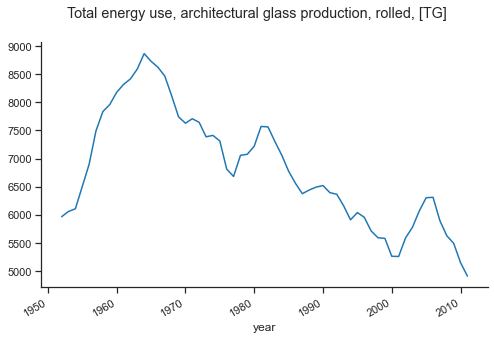

In [137]:
((BE_FR['Total energy use, architectural glass [TJ]']
 .rolling(5, center = True)
 .mean())
 .plot(subplots=True,
       grid=False, 
       figsize=(8, 5),
       sharex=True, sharey=True,
       title=
       ("Total energy use, architectural glass production, rolled, [TG]")
      )
)
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# The CO2 Emissions of the Flat Glass Iindustry

## Absolute CO2 Emissions, Europe

In [196]:
# Estimating the CO2 emission related to flat glass production
EU['CO2, flat glass [kt]'] = (
    EU['Production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [197]:
# Estimating the CO2 emission related to architectural flat glass production
EU['CO2, architectural glass [kt]'] = (
    EU['arch glass production [kt]']
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
)

In [198]:
CO2_G = ['CO2, flat glass [kt]', 'CO2, architectural glass [kt]']

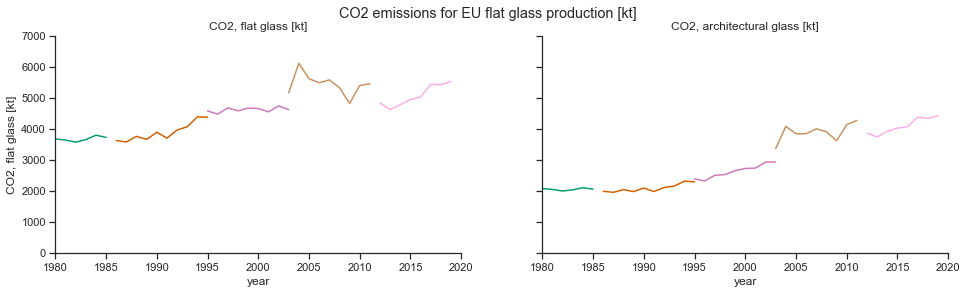

In [199]:
EUplot = EU.reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, CO2) in enumerate(zip(axes.flatten(), CO2_G)):

    sns.lineplot(data=EUplot,
                 x='year', y=f"{CO2}",
                 hue = 'Nbr of countries', 
                 palette = 'colorblind',
                 ax = ax)
    ax.set_title(CO2)
    ax.set_xlim(1980,2020)
    ax.set_ylim(0,7000)
    ax.get_legend().remove()

fig.suptitle("CO2 emissions for EU flat glass production [kt]")
fig.subplots_adjust(hspace = 0.4)
sns.despine()
plt.show()

## Absolute CO2 Emissions in Belgium and France since 1945


In [141]:
# Estimating the CO2 emission related to flat glass production
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('CO2, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [142]:
# Estimating the CO2 emission related to architectural flat glass production
for country in BE_FR['Architectural glass production [kt]'].columns:
    BE_FR[('CO2, architectural glass [kt]', country)] = (
        BE_FR[('Architectural glass production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

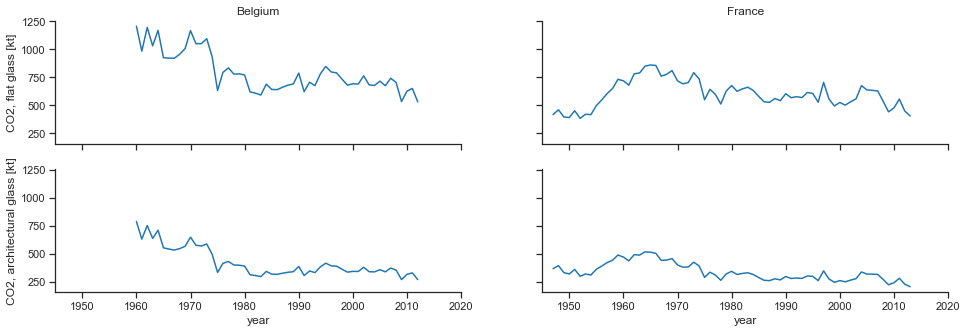

In [144]:
nrows = len(CO2_G)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))
for row, CO2 in enumerate(CO2_G):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR[(f"{CO2}", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

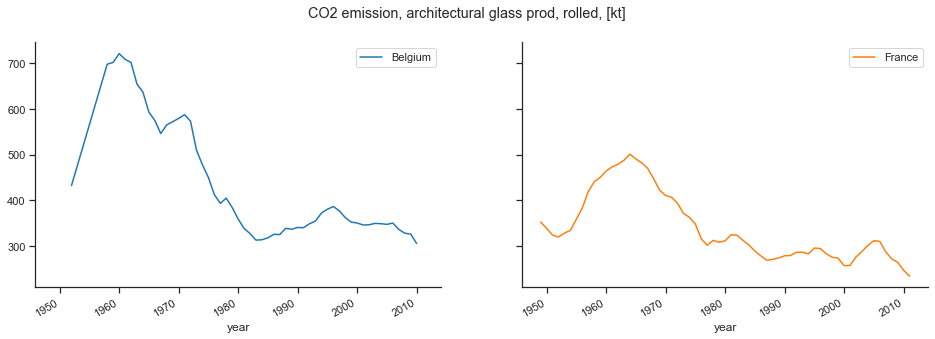

In [145]:
#Rolling and plotting the CO2 emission related to architectural glass prod
with sns.plotting_context("notebook"):
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title=
                   ("CO2 emission, architectural glass prod, rolled, [kt]")
                  )
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Base 100 Analysis, France and Belgium

In [146]:
# Base 100 = 1980
FGProd_diff = (100 * BE_FR['Production [kt]'] 
               / BE_FR['Production [kt]'].loc[1980]
              )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * BE_FR['CO2, flat glass [kt]'] 
               / BE_FR['CO2, flat glass [kt]'].loc[1980]
              )

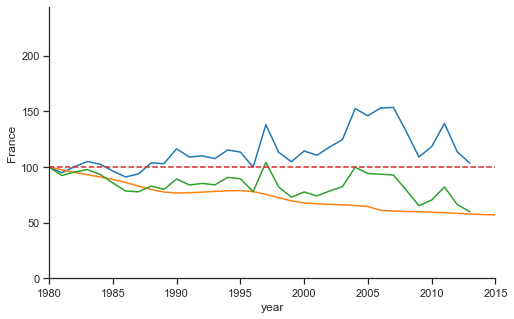

In [147]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = FGProd_diff, 
             x = FGProd_diff.index, 
             y = 'France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [148]:
# Base 100 = 1980, with a 5-year rolling
FGProd_diff_roll = (100 * BE_FR['Production [kt]']
                    .rolling(5, center=True).mean() 
                    / BE_FR['Production [kt]']
                    .rolling(5, center = True).mean().loc[1980])

CO2ABS_diff_roll = (100 * (BE_FR['CO2, flat glass [kt]']
                           .interpolate(method="linear", limit_area='inside')
                           .rolling(5, center = True).mean()) 
                    / (BE_FR['CO2, flat glass [kt]']
                       .interpolate(method="linear", limit_area='inside')
                       .rolling(5, center=True).mean().loc[1980])
                   )

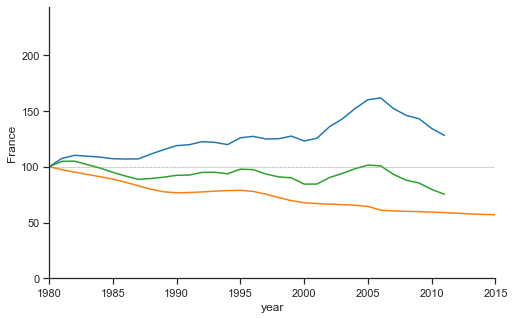

In [149]:
# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=FGProd_diff_roll,
             x=FGProd_diff_roll.index,
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])

ax.plot(CO2ABS_diff_roll.index, 
        CO2ABS_diff_roll['France'])

ax.plot([1980, 2015], [100, 100], '--', c='grey', linewidth=0.5)

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary

# MEFA of Insulating Glass Units in Europe

## Creating a Dataframe for the Flows of IGU

In [160]:
# Creating a new DataFrame for European IGU flows

EU_IGU = pd.concat([EU_Prod['IGU, "000 m²']/1000,
                    EU_Imp['IGU, "000 m²']/1000,
                    EU_Exp['IGU, "000 m²']/1000],
                  axis=1, keys=[('Production [10^6 m²]'),
                                ('Import [10^6 m²]'),
                                ('Export [10^6 m²]')],
                  names=['Flow']).stack(dropna=False)

EU_IGU = EU_IGU.unstack()

In [161]:
EU_IGU

Flow                   Production [10^6 m²]  Import [10^6 m²]  \
Nbr of countries year                                           
6                1945                   NaN               NaN   
                 1946                   NaN               NaN   
                 1947                   NaN               NaN   
                 1948                   NaN               NaN   
                 1949                   NaN               NaN   
...                                     ...               ...   
28               2015                116.00              0.87   
                 2016                114.00              1.00   
                 2017                121.60              2.12   
                 2018                117.01              1.02   
                 2019                121.06              2.32   

Flow                   Export [10^6 m²]  
Nbr of countries year                    
6                1945               NaN  
                 1946               NaN  
                 1947               NaN  
                 1948               NaN  
                 1949               NaN  
...                                 ...  
28               2015              2.83  
                 2016              2.94  
                 2017              3.41  
                 2018              3.20  
                 2019              3.42  

[77 rows x 3 columns]

In [162]:
# Adding columns for data in [kt], 
# to be used later for material/energy/carbon intensity
# 2500kg/m³ and in average 9mm thick

EU_IGU['Production [kt]'] = EU_IGU['Production [10^6 m²]'] * 2.5 * 9
EU_IGU['Import [kt]'] = EU_IGU['Import [10^6 m²]'] * 2.5 * 9
EU_IGU['Export [kt]'] = EU_IGU['Export [10^6 m²]'] * 2.5 * 9

## Production of Insulating Glass Units

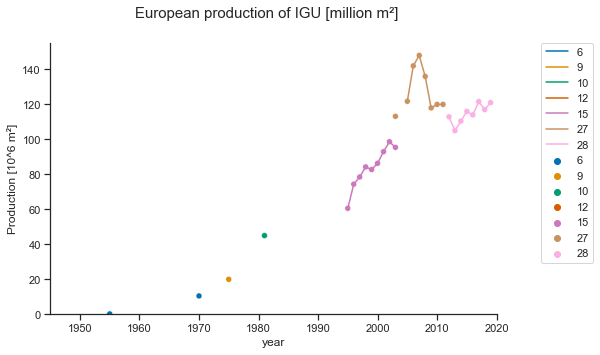

In [163]:
# Plot the European production of flat glass

EU_IGU_plot = EU_IGU.reset_index()

fig, ax = plt.subplots(figsize=(8,5))

x = EU_IGU_plot['year']
y = EU_IGU_plot['Production [10^6 m²]']

sns.scatterplot(data = EU_IGU_plot, 
                   x = x, y = y,
                   hue = 'Nbr of countries', 
                   palette = 'colorblind',
                   ax = ax)

sns.lineplot(data = EU_IGU_plot, 
             x = x, y = y,
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)


ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of IGU [million m²]', fontsize = 15)
plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
sns.despine()
plt.show()

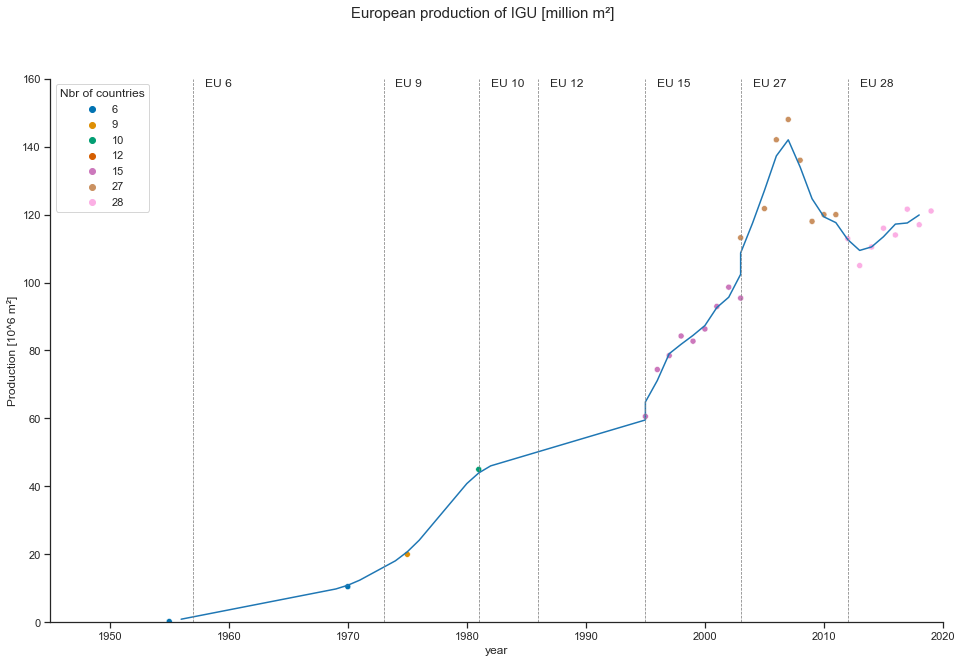

In [164]:
fig, ax = plt.subplots(figsize=(16,10))

# Plot EU production of IGU, 'real' data
sns.scatterplot(data = EU_IGU_plot, 
                x = EU_IGU_plot['year'], 
                y = EU_IGU_plot['Production [10^6 m²]'],
                hue = 'Nbr of countries', 
                palette = 'colorblind',
                ax = ax)

# Plot a trend curve
ax.plot(EU_IGU['Production [10^6 m²]'].reset_index(level='Nbr of countries')
        .sort_values(by=['year'])
        .interpolate().rolling(3, center = True)
        .mean()['Production [10^6 m²]']
       )

# plot lines highlightining changes in the scope, i.e. EU enlargement
EU_Kdates = {'EU 6':1957, 'EU 9':1973, 'EU 10':1981, 'EU 12':1986, 'EU 15':1995, 
             'EU 27':2003, 'EU 28':2012}

for y, x in EU_Kdates.items():
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.75)
    plt.text(x+1, 160, f"{y}",
             verticalalignment='top')

ax.set_xlim(1945, 2020)
ax.set_ylim(0, 160)
fig.suptitle('European production of IGU [million m²]', fontsize = 15)
sns.despine()

# MEFA of Insulating Glass Units in France and Belgium

## Creating a Dataframe for the Flows of IGU

In [165]:
# Creating a new DataFrame for Belgian and French IGU flows
BE_FR_IGU = (
    pd.concat([FR_Prod['IGU, kt'], BE_Prod['IGU, kt'],
               FR_Prod['IGU, "000 m²'], BE_Prod['IGU, "000 m²'], 
               FR_Imp['IGU, kt'], BE_Imp['IGU, kt'], 
               FR_Imp['IGU, "000 m²'], BE_Imp['IGU, "000 m²'],
               FR_Exp['IGU, kt'], BE_Exp['IGU, kt'], 
               FR_Exp['IGU, "000 m²'], BE_Exp['IGU, "000 m²']],
              axis=1, 
              keys=[('Production [kt]', 'France'), 
                    ('Production [kt]', 'Belgium'),
                    ('Production [000 m²]', 'France'), 
                    ('Production [000 m²]', 'Belgium'),
                    ('Import [kt]', 'France'), 
                    ('Import [kt]', 'Belgium'),
                    ('Import [000 m²]', 'France'), 
                    ('Import [000 m²]', 'Belgium'),
                    ('Export [kt]', 'France'), 
                    ('Export [kt]', 'Belgium'),
                    ('Export [000 m²]', 'France'), 
                    ('Export [000 m²]', 'Belgium')],
              names=['Info', 'Country'])).stack(level=- 1, 
                                                dropna=False)

BE_FR_IGU = BE_FR_IGU.unstack()

In [166]:
BE_FR_IGU

Info    Export [000 m²]         Export [kt]        Import [000 m²]          \
Country         Belgium  France     Belgium France         Belgium  France   
year                                                                         
1945                NaN     NaN         NaN    NaN             NaN     NaN   
1946                NaN     NaN         NaN    NaN             NaN     NaN   
1947                NaN     NaN         NaN    NaN             NaN     NaN   
1948                NaN     NaN         NaN    NaN             NaN     NaN   
1949                NaN     NaN         NaN    NaN             NaN     NaN   
...                 ...     ...         ...    ...             ...     ...   
2016             785.81  507.43       21.61  11.42          427.39  346.62   
2017             720.03  630.42       19.80  14.18          450.06  321.06   
2018             761.39  651.88       20.94  14.67          360.80  437.02   
2019                NaN  820.09         NaN  18.45          609.48  413.43   
2020                NaN     NaN         NaN    NaN             NaN     NaN   

Info    Import [kt]        Production [000 m²]           Production [kt]  \
Country     Belgium France             Belgium    France         Belgium   
year                                                                       
1945            NaN    NaN                 NaN       NaN             NaN   
1946            NaN    NaN                0.00      0.00            0.00   
1947            NaN    NaN                 NaN       NaN             NaN   
1948            NaN    NaN                 NaN       NaN             NaN   
1949            NaN    NaN                 NaN       NaN             NaN   
...             ...    ...                 ...       ...             ...   
2016           9.83   7.80             3946.62  15192.06           88.80   
2017          10.35   7.22             4192.64  15696.88           94.33   
2018           8.30   9.83             4124.61  16462.59           92.80   
2019          14.02   9.30             4349.46  17206.73           97.86   
2020            NaN    NaN                 NaN       NaN             NaN   

Info             
Country  France  
year             
1945        NaN  
1946       0.00  
1947        NaN  
1948        NaN  
1949        NaN  
...         ...  
2016     341.82  
2017     353.18  
2018     370.41  
2019     387.15  
2020        NaN  

[76 rows x 12 columns]

## Production of Insulating Glass Units

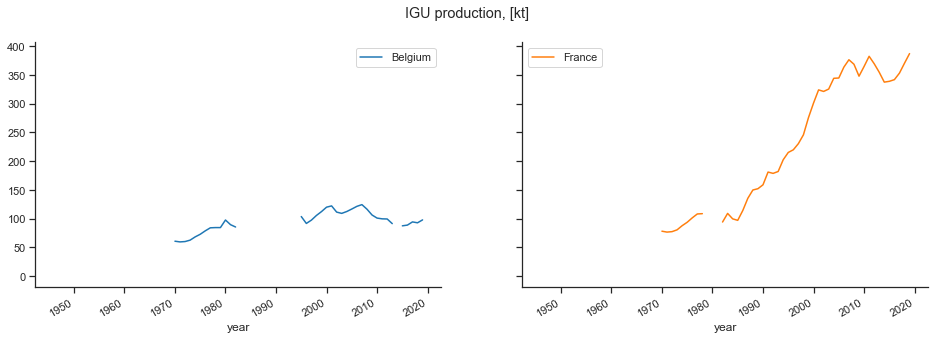

In [167]:
#Plotting the Frnech and Belgian IGU production since 1945
BE_FR_IGU['Production [kt]'].plot(subplots=True, 
                                  grid=False,
                                  layout=(1, 2), 
                                  figsize=(16,5),
                                  sharex=True, sharey=True,
                                  title="IGU production, [kt]")
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

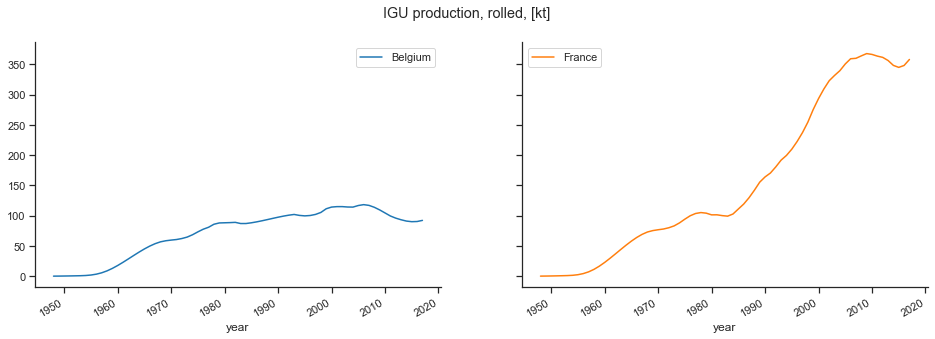

In [168]:
# Plotting the interpolated and 5-y. rolled French and Belgian IGU production
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR_IGU['Production [kt]']
     .interpolate(method="pchip", 
                  limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 5),
                   sharex=True, sharey=True,
                   title="IGU production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

In [169]:
# Interpolating and rolling of the French and Belgian IGU production
BE_FR_IGU['Production [kt]'] = (BE_FR_IGU['Production [kt]']
                                .interpolate(method="pchip", 
                                             limit_area='inside')
                               )

BE_FR_IGU['Production [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                    .interpolate(method="pchip", 
                                                 limit_area='inside')
                                   )

## Consumption of Insulating Glass Units

In [170]:
ratios = ['Import', 'Export']
countries = ['Belgium', 'France']

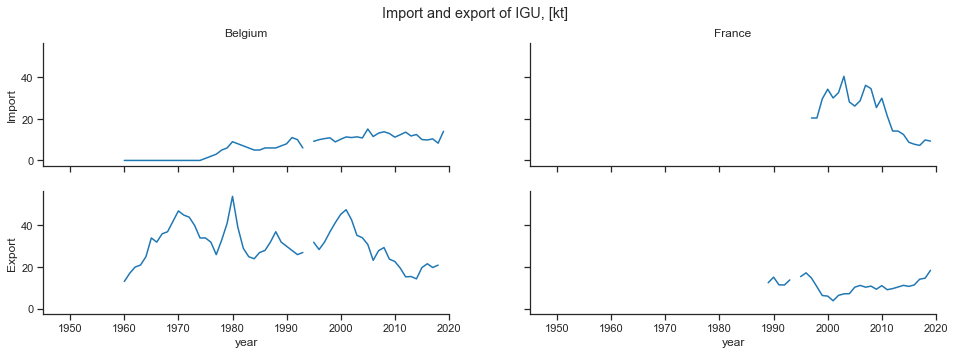

In [171]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        BE_FR_IGU[(f"{ratio} [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

fig.suptitle('Import and export of IGU, [kt]')
sns.despine()
plt.show()

In [172]:
for ratio in ratios:
        BE_FR_IGU[f"{ratio} [kt]"] = (BE_FR_IGU[f"{ratio} [kt]"]
                                      .interpolate(method='linear', 
                                                   limit_area='inside')
                                      )

        BE_FR_IGU[f"{ratio} [000 m²]"] = (BE_FR_IGU[f"{ratio} [000 m²]"]
                                          .interpolate(method='linear', 
                                                       limit_area='inside')
                                          )

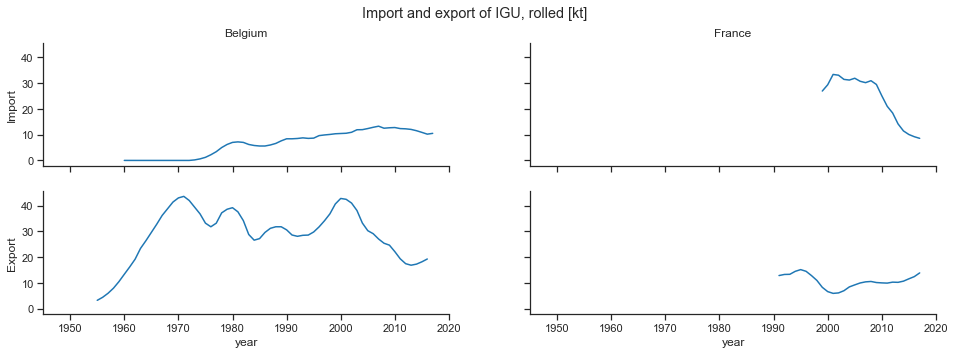

In [173]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,5))

for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR_IGU[(f"{ratio} [kt]", country)]
         .rolling(5, center=True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)
fig.suptitle('Import and export of IGU, rolled [kt]')
sns.despine()
plt.show()

In [174]:
BE_FR_IGU = BE_FR_IGU.stack()

BE_FR_IGU['Consumption [kt]'] = (BE_FR_IGU['Production [kt]']
                                 + BE_FR_IGU['Import [kt]']
                                 - BE_FR_IGU['Export [kt]']
                                )

BE_FR_IGU['Consumption [000 m²]'] = (BE_FR_IGU['Production [000 m²]']
                                     + BE_FR_IGU['Import [000 m²]']
                                     - BE_FR_IGU['Export [000 m²]']
                                    )

BE_FR_IGU = BE_FR_IGU.unstack()

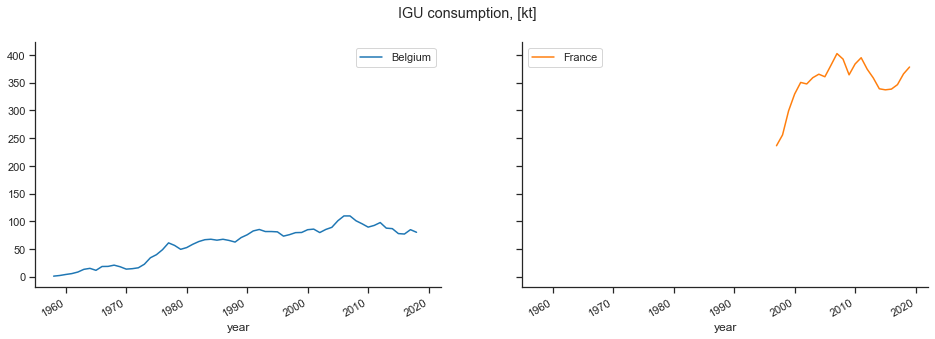

In [175]:
#Plotting the Frnech and Belgian IGU consumption since 1945
BE_FR_IGU['Consumption [kt]'].plot(subplots=True,
                                   grid=False,
                                   layout=(1, 2), 
                                   figsize=(16, 5),
                                   sharex=True, sharey=True,
                                   title="IGU consumption, [kt]")
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [176]:
# Estimating the IGU consumption per capita
for country in BE_FR_IGU['Consumption [kt]'].columns:
    BE_FR_IGU[('IGU consumption [m²/cap]', country)] = (
        BE_FR_IGU[('Consumption [000 m²]', country)]
        / BE_FR_Pop[('Population [x1000]', country)])

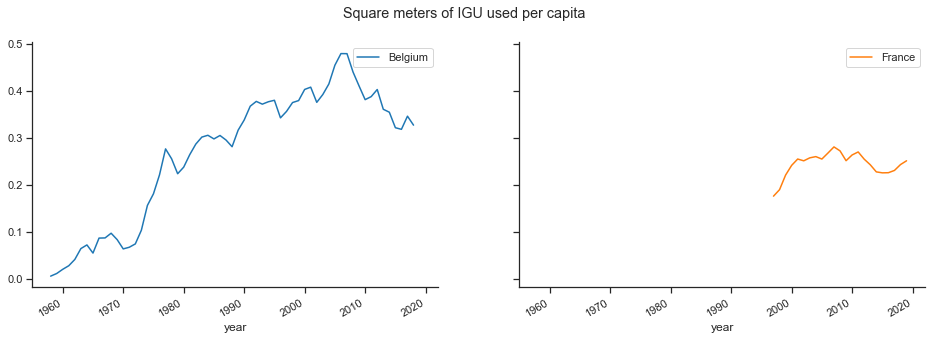

In [177]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .plot(subplots=True,
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita")
)
ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

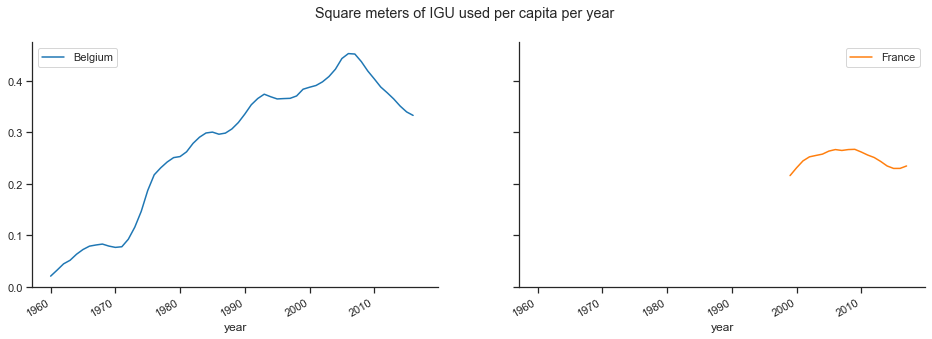

In [178]:
# Plotting the French and Belgian IGU consumption per capita
(BE_FR_IGU['IGU consumption [m²/cap]']
 .rolling(5, center=True)
 .mean()
 .plot(subplots=True,
       grid=False,
       layout=(1, 2), 
       figsize=(16, 5),
       sharex=True, sharey=True,
       title="Square meters of IGU used per capita per year")
)

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Raw Material Use for IGU Production

In [179]:
# Absolute use of raw materials for IGU production:
for mat in materials:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{mat}, production [kt]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

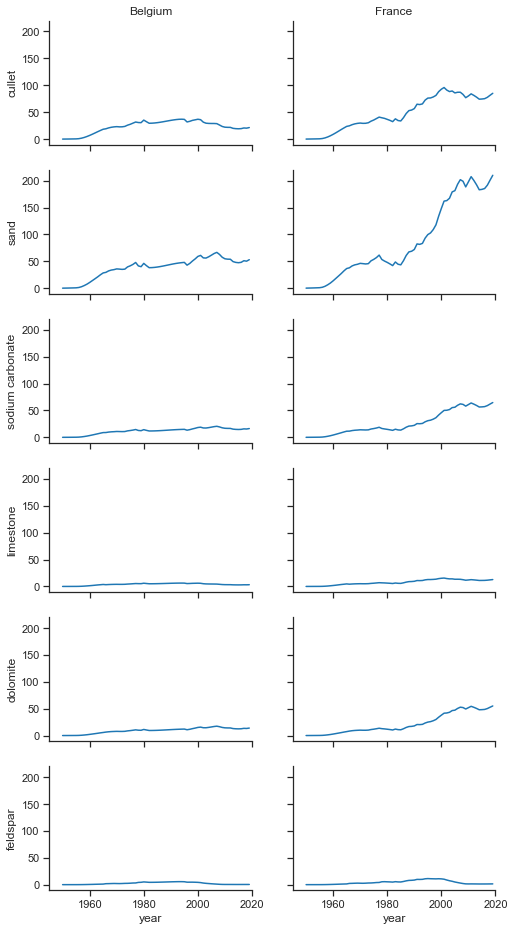

In [180]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16))

for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR_IGU[(f"{material}, production [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

In [181]:
BE_FR_IGU['Total raw material use, production [kt]'] = 0

for material in materials:
    BE_FR_IGU['Total raw material use, production [kt]'] = (
        BE_FR_IGU[(f"{material}, production [kt]", country)] 
        + BE_FR_IGU['Total raw material use, production [kt]']
    )

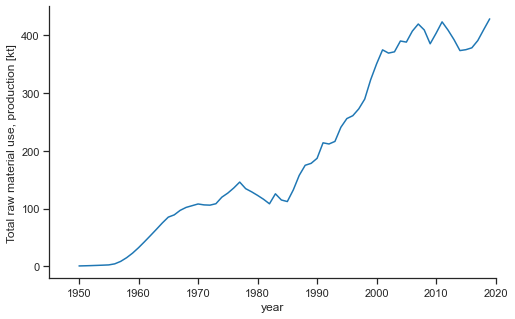

In [182]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR_IGU, 
             x = BE_FR_IGU.index, 
             y = 'Total raw material use, production [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

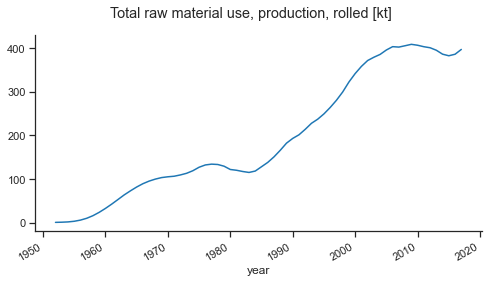

In [183]:
(BE_FR_IGU['Total raw material use, production [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, production, rolled [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy use for IGU Production

In [184]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR_IGU['Production [kt]'].columns:
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] = (
            BE_FR_IGU[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

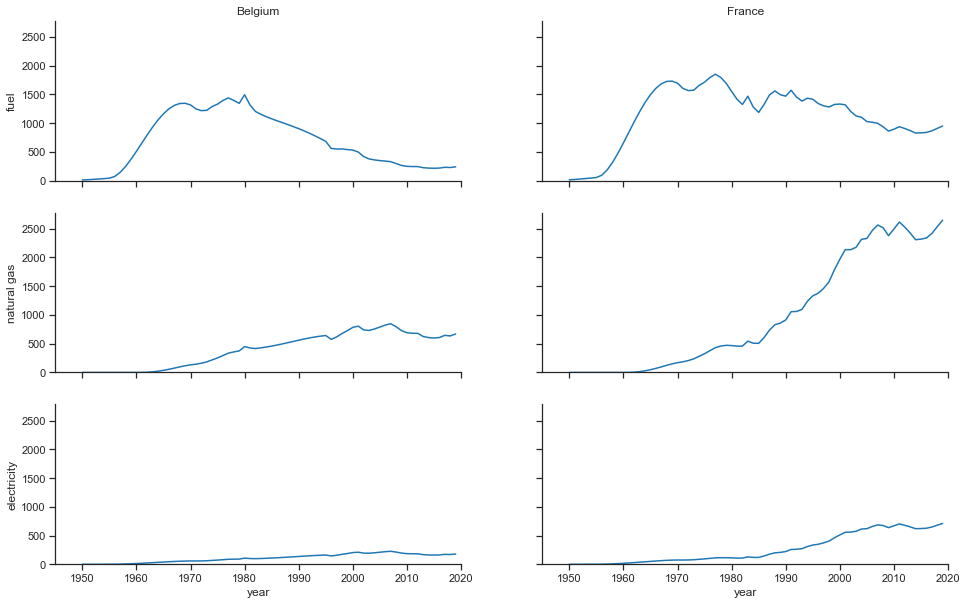

In [185]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,10))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR_IGU[(f"{energy}, production [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

sns.despine()
plt.show()

In [186]:
BE_FR_IGU['Total energy use, production [TJ]'] = 0

for energy in energies:
    BE_FR_IGU['Total energy use, production [TJ]'] = (
        BE_FR_IGU[(f"{energy}, production [TJ]", country)] 
        + BE_FR_IGU['Total energy use, production [TJ]']
    )

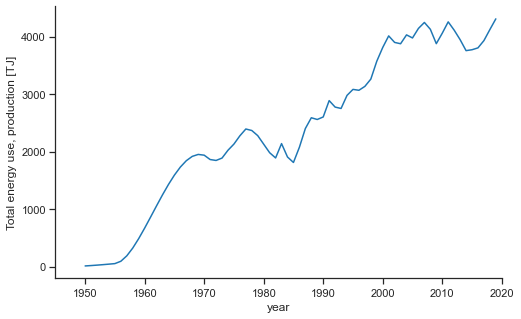

In [187]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data = BE_FR_IGU, 
             x = BE_FR_IGU.index, 
             y = 'Total energy use, production [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

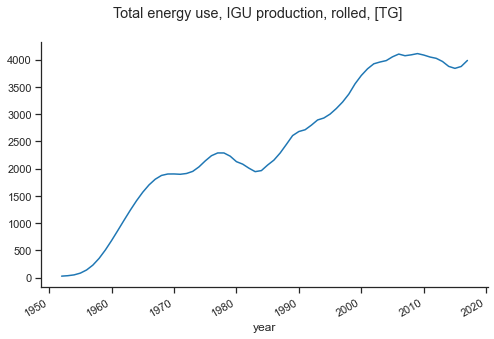

In [188]:
(BE_FR_IGU['Total energy use, production [TJ]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 5),
               sharex=True, sharey=True,
               title=
               ("Total energy use, IGU production, rolled, [TG]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## CO2 Emissions Relating to IGU Production and Consumption in France and Belgium

In [189]:
# Estimating the CO2 emission related to IGU production
for country in BE_FR_IGU['Production [kt]'].columns:
    BE_FR_IGU[('CO2, IGU production [ktCO2]', country)] = (
        BE_FR_IGU[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [190]:
# Estimating the CO2 emission related to IGU consumption
for country in BE_FR['Consumption [kt]'].columns:
    BE_FR_IGU[('CO2, IGU consumption [ktCO2]', country)] = (
        BE_FR_IGU[('Consumption [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [191]:
BE_FR_IGU

Info    Export [000 m²]         Export [kt]        Import [000 m²]          \
Country         Belgium  France     Belgium France         Belgium  France   
year                                                                         
1946                NaN     NaN         NaN    NaN             NaN     NaN   
1947                NaN     NaN         NaN    NaN             NaN     NaN   
1948                NaN     NaN         NaN    NaN             NaN     NaN   
1949                NaN     NaN         NaN    NaN             NaN     NaN   
1950                NaN     NaN         NaN    NaN             NaN     NaN   
...                 ...     ...         ...    ...             ...     ...   
2015             718.00  476.73       19.74  10.73          436.76  387.24   
2016             785.81  507.43       21.61  11.42          427.39  346.62   
2017             720.03  630.42       19.80  14.18          450.06  321.06   
2018             761.39  651.88       20.94  14.67          360.80  437.02   
2019                NaN  820.09         NaN  18.45          609.48  413.43   

Info    Import [kt]        Production [000 m²]            ...  \
Country     Belgium France             Belgium    France  ...   
year                                                      ...   
1946            NaN    NaN                0.00      0.00  ...   
1947            NaN    NaN                0.79      1.01  ...   
1948            NaN    NaN                3.09      3.98  ...   
1949            NaN    NaN                6.82      8.78  ...   
1950            NaN    NaN               11.89     15.30  ...   
...             ...    ...                 ...       ...  ...   
2015          10.05   8.71             3889.60  15062.70  ...   
2016           9.83   7.80             3946.62  15192.06  ...   
2017          10.35   7.22             4192.64  15696.88  ...   
2018           8.30   9.83             4124.61  16462.59  ...   
2019          14.02   9.30             4349.46  17206.73  ...   

Info    fuel, production [TJ] natural gas, production [TJ]           \
Country                France                      Belgium   France   
year                                                                  
1946                      NaN                          NaN      NaN   
1947                      NaN                          NaN      NaN   
1948                      NaN                          NaN      NaN   
1949                      NaN                          NaN      NaN   
1950                    13.22                         0.00     0.00   
...                       ...                          ...      ...   
2015                   830.33                       598.61  2318.15   
2016                   837.46                       607.38  2338.06   
2017                   865.29                       645.25  2415.75   
2018                   907.50                       634.78  2533.59   
2019                   948.52                       669.38  2648.12   

Info    electricity, production [TJ]          \
Country                      Belgium  France   
year                                           
1946                             NaN     NaN   
1947                             NaN     NaN   
1948                             NaN     NaN   
1949                             NaN     NaN   
1950                            0.19    0.25   
...                              ...     ...   
2015                          160.59  621.90   
2016                          162.95  627.24   
2017                          173.10  648.08   
2018                          170.30  679.70   
2019                          179.58  710.42   

Info    Total energy use, production [TJ] CO2, IGU production [ktCO2]          \
Country                                                       Belgium  France   
year                                                                            
1946                                  NaN                         NaN     NaN   
1947

In [192]:
CO2_IGU = ['production', 'consumption']

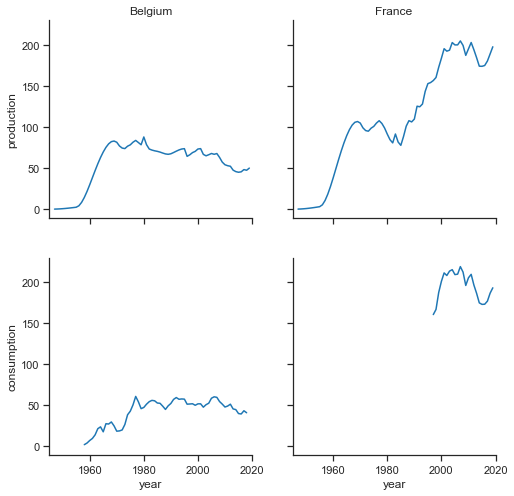

In [193]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

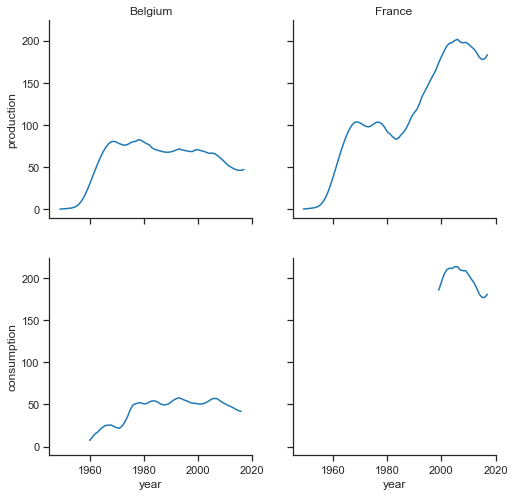

In [194]:
nrows = len(CO2_IGU)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,8))

for row, CO2 in enumerate(CO2_IGU):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        (BE_FR_IGU[(f"CO2, IGU {CO2} [ktCO2]", country)]
         .rolling(5, center=True).mean().
         plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

sns.despine()
plt.show()

## CO2 Emissions: Base 100 Analysis

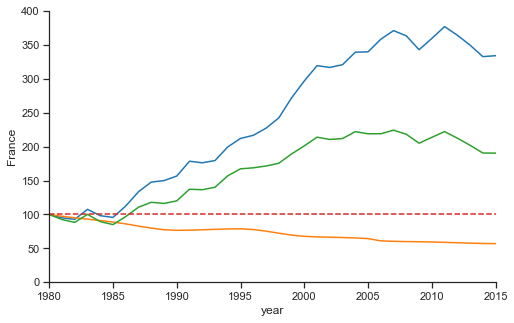

In [195]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                / BE_FR_IGU['Production [kt]'].loc[1980]
               )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]'] 
                  / BE_FR_IGU['CO2, IGU production [ktCO2]'].loc[1980]
                 )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff, 
             x=IGUProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index, 
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Base 100 = 1980
IGUProd_diff = (100 * BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                / BE_FR_IGU['Production [kt]']
                .rolling(5, center=True).mean()
                .loc[1980]
               )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_IGUdiff = (100 * BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean() 
                  / BE_FR_IGU['CO2, IGU production [ktCO2]']
                  .rolling(5, center=True).mean()
                  .loc[1980]
                 )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=IGUProd_diff, 
             x=IGUProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_IGUdiff.index, 
        CO2ABS_IGUdiff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Summary